In [7]:
import torch
from pymonntorch import (
    NeuronGroup,
    NeuronDimension,
    EventRecorder,
    Recorder,
    SynapseGroup,
)
from conex import (
    Neocortex,
    NeuronAxon,
    SpikeTrace,
    SimpleDendriteComputation,
    SimpleDendriteStructure,
    LIF,
)
from conex import (
    Synapsis,
    SynapseInit,
    WeightInitializer,
    Conv2dDendriticInput,
    Conv2dSTDP,
    prioritize_behaviors,
    Fire,
)
from conex import ActivityBaseHomeostasis, KWTA, LateralDendriticInput
from conex.helpers import Poisson
import conex.helpers.filters as filters

from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    WeightNormalization,
)

from matplotlib import pyplot as plt

In [8]:
import Input as InpData
from convolution import convolve, convolve3d, batch_convolve
import readPicture as OpenPicture

from Plot_Part2 import plot_grid
# import plots.gifMaker as gif

from encoding import encode

In [9]:
def prepare_data(
    data_rng=range(1, 9),
    sigma_1=10/15,
    sigma_2=3/15,
    one_sum=True,
    show_images=False,
    sizes=[3, 7, 11],
):

    size1 = sizes[0]
    f1 = torch.tensor(
        filters.DoGFilter(
            size1, sigma_1=size1 * sigma_1, sigma_2=size1 * sigma_2, one_sum=True
        ),
    )
    f1 = f1 / (torch.abs(f1)).max()

    size2 = sizes[1]
    f2 = torch.tensor(
        filters.DoGFilter(
            size2, sigma_1=size2 * sigma_1, sigma_2=size2 * sigma_2, one_sum=True
        ),
    )
    f2 = f2 / (torch.abs(f2)).max()

    size3 = sizes[2]
    f3 = torch.tensor(
        filters.DoGFilter(
            size3, sigma_1=size3 * sigma_1, sigma_2=size3 * sigma_2, one_sum=True
        ),
    )
    f3 = f3 / (torch.abs(f3)).max()

    temp = [
        convolve(
            f"Sample{i}.jpeg",
            # useTorch=True,
            prefix="./pictures/",
            n=100,
            show_image=show_images,
            filter=filter,
            flatten=True,
            return_both=False,
        )
        for filter in [f1, f2, f3]
        for i in data_rng
    ]
    data = []
    for d in temp:
        data += [d]

    return {
        "data": data,
        "parameters": [
            {
                f"f{size1}_size": size1,
                f"f{size1}_sigma_1": size1 * sigma_1,
                f"f{size1}_sigma_2": size1 * sigma_2,
            },
            {
                f"f{size2}_size": size2,
                f"f{size2}_sigma_1": size2 * sigma_1,
                f"f{size2}_sigma_2": size2 * sigma_2,
            },
            {
                f"f{size3}_size": size3,
                f"f{size3}_sigma_1": size3 * sigma_1,
                f"f{size3}_sigma_2": size3 * sigma_2,
            },
        ],
    }

In [10]:
data, temp_parameters = prepare_data(
    show_images=False, 
    data_rng=range(1, 9), 
    sizes=[3, 5, 7]
).values()
parameters = []
for d in temp_parameters:
    for item in d:
        parameters.append(f"{item}: {d[item]}")
print(parameters)

['f3_size: 3', 'f3_sigma_1: 2.0', 'f3_sigma_2: 0.6000000000000001', 'f5_size: 5', 'f5_sigma_1: 3.333333333333333', 'f5_sigma_2: 1.0', 'f7_size: 7', 'f7_sigma_1: 4.666666666666666', 'f7_sigma_2: 1.4000000000000001']


/var/folders/60/rr8w8y8x6399dlnmxj3z_kzr0000gn/T/ipykernel_11730/2215827067.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1 = torch.tensor(
/var/folders/60/rr8w8y8x6399dlnmxj3z_kzr0000gn/T/ipykernel_11730/2215827067.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f2 = torch.tensor(
/var/folders/60/rr8w8y8x6399dlnmxj3z_kzr0000gn/T/ipykernel_11730/2215827067.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f3 = torch.tensor(


In [11]:
def train(
    data,
    height=100,
    width=100,
    iterations=900,
    OUT_R=10,
    OUT_THRESHOLD=15,
    OUT_TAU=3,
    OUT_V_RESET=0,
    OUT_V_REST=5,
    input_channels=1,
    kernel_height=100,
    kernel_width=100,
    f=8,
    activity_rate=0.2,
    window_siz=10,
    encode_method="ITL",
    show_weights=True,
    show_last_spike=True,
    show_mean_spike=True,
    show_result_spike=True,
    show_activity=False,
    print_convolution_result=True,
    rest_time=10,
    weight_mode="ones",
    AP=2,
    AM=1,
    K=1,
    s=0.1,
    J_0_lateral=1000,
):

    layer2_height, layer2_width = (
        height - kernel_height + 1,
        width - kernel_width + 1,
    )
    net = Neocortex(dt=1, device="cpu", dtype=torch.float32)
    ng1 = NeuronGroup(
        size=NeuronDimension(height=height, width=width),
        net=net,
        behavior={
            **prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        R=OUT_R,
                        threshold=OUT_THRESHOLD,
                        tau=OUT_TAU,
                        v_reset=OUT_V_RESET,
                        v_rest=OUT_V_REST,
                    ),  # 260
                    Fire(),  # 340
                    SpikeTrace(tau_s=3),
                    NeuronAxon(),
                ]
            ),
            **{
                10: InpData.ResetMemory(),
                345: InpData.Encode(
                    data=torch.tensor(data),
                    # range=255,
                    time=window_siz,
                    sparsity=1,
                    input_period=window_siz + rest_time,
                    ratio=0.05,
                    method=encode_method,
                ),
                # 350: act.Activity(),
                460: Recorder(
                    variables=["v", "I"],
                    tag="in_recorder",
                ),
                461: EventRecorder("spikes", tag="in_ev_recorder"),
            },
        },   
    )

    ng2 = NeuronGroup(
        size=NeuronDimension(depth=f, height=layer2_height, width=layer2_width),
        net=net,
        behavior={
            **prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        tau=10,
                        v_rest=0,
                        v_reset=0,
                        threshold=1,
                        R=1,
                    ),
                    KWTA(k=K, dimension=0),
                    Fire(),
                    SpikeTrace(tau_s=10.0),
                    NeuronAxon(),
                    ActivityBaseHomeostasis(
                        activity_rate=activity_rate * window_siz,
                        window_size=(window_siz + rest_time),
                        updating_rate=0.1,
                    ),
                ]
            ),
            **{
                460: Recorder(variables=["spikes"], tag="out_recorder"),
                461: EventRecorder(
                    variables=["I", "spikes"], tag="out_ev_recorder"
                ),
            },
        },
    )
    synapse_input_layer2 = Synapsis(
        net=net,
        src=ng1,
        dst=ng2,
        synaptic_tag="Proximal",
        synapsis_behavior={
            **prioritize_behaviors(
                [
                    SynapseInit(),
                    WeightNormalization(),
                    WeightInitializer(
                        mode=weight_mode,
                        scale=5,
                        weight_shape=(f, input_channels, kernel_height, kernel_width),
                        kernel_shape=(f, input_channels, kernel_height, kernel_width),
                    ),
                    Conv2dDendriticInput(
                        current_coef= 20,
                    ),
                    Conv2dSTDP(
                        a_plus=AP * (kernel_height * kernel_width),
                        a_minus=AM * (kernel_height * kernel_width),
                        w_max=2 / (kernel_height * kernel_width),
                        positive_bound="soft_bound",
                        negative_bound="soft_bound",
                    ),
                ]
            ),
            **{
                460: Recorder(tag="synapse_recorder", variables=["weights"]),
            },
        },
    )

    lateral_inhibition = Synapsis(
        net=net,
        src=ng2,
        dst=ng2,
        synaptic_tag="Proximal",
        synapsis_behavior=prioritize_behaviors(
            [
                SynapseInit(),
                WeightInitializer(
                    mode="ones",
                    scale=0.5,
                    weight_shape=(1, 1, 2 * f + 1, 1, 1),
                    kernel_shape=(1, 1, 2 * f + 1, 1, 1),
                ),
                LateralDendriticInput(inhibitory=True, current_coef=J_0_lateral),
            ]
        ),
    )
    net.initialize(info=False)
    net.simulate_iterations(iterations)
    spikes = ng2.spikes.reshape(f, layer2_height, layer2_width)
    # spikes = ng2.spikes
    if show_activity:
        plt.scatter(
            ng1["in_ev_recorder", 0].variables["spikes"][:, 0].cpu(),
            ng1["in_ev_recorder", 0].variables["spikes"][:, 1].cpu(),
            s=s,
        )
        plt.title("input activity")
        plt.show()

        plt.scatter(
            ng2["out_ev_recorder", 0].variables["spikes"][:, 0].cpu(),
            ng2["out_ev_recorder", 0].variables["spikes"][:, 1].cpu(),
            s=s,
        )
        plt.title("output activity")

        plt.show()

    # print (synapse_input_layer2.weights.shape)
    if show_weights:
        plot_grid(
            synapse_input_layer2.synapses[0].weights.reshape(
                f, kernel_height, kernel_width
            ),
            f=f,
        )
        
    if show_last_spike:
        spikes = ng2.spikes.reshape(f, layer2_height, layer2_width)
        plot_grid(spikes, f=f, title="Last spikes")

    if show_mean_spike:
        spikes = (
            ng2[460, 0]
            .variables["spikes"]
            .reshape(iterations, f, layer2_height, layer2_width)
        )
        spikes = spikes.sum(axis=0, keepdim=True)[0]
        plot_grid(spikes, f=f, title="Mean of spikes")
    if show_result_spike:
        for i in range(f):

            spikes = (
                ng2[460, 0]
                .variables["spikes"]
                .reshape(iterations, f, layer2_height, layer2_width)[
                    -(window_siz + rest_time) * (i + 1) : -(window_siz + rest_time) * i
                ]
            )
            spikes = spikes.sum(axis=0, keepdim=True)[0]
            plot_grid(spikes, f=f, title="Spiking Convolution Result")

    return net

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 27241.347ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


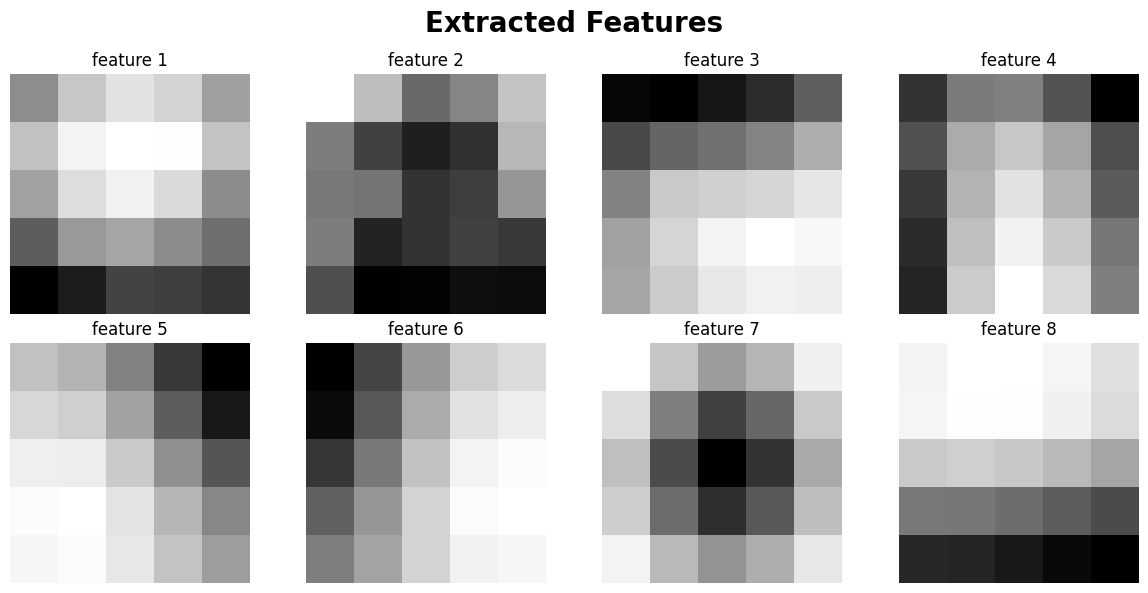

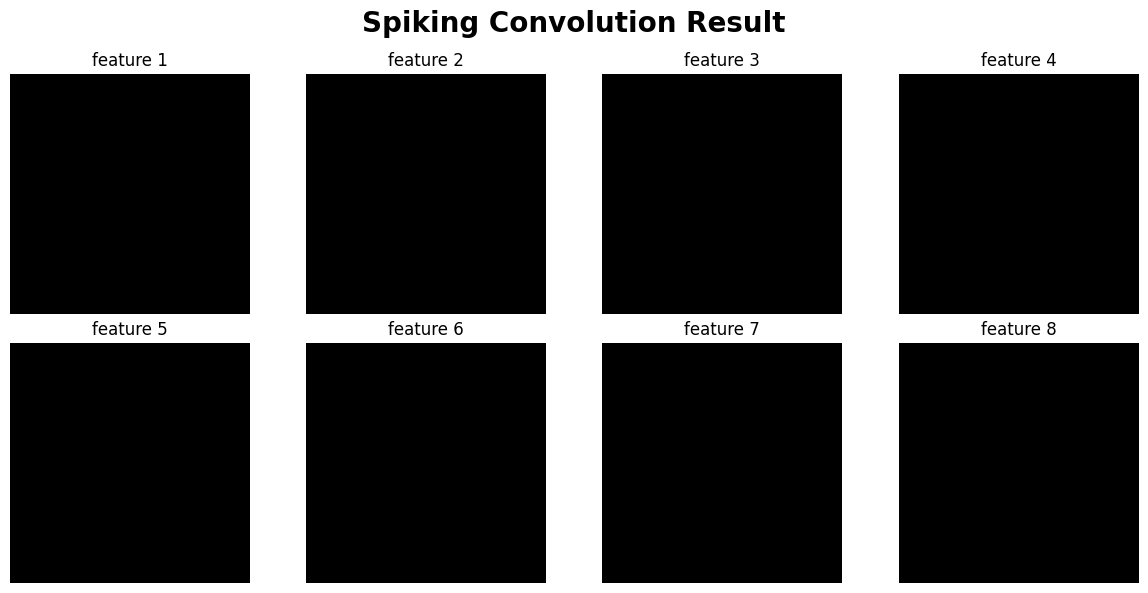

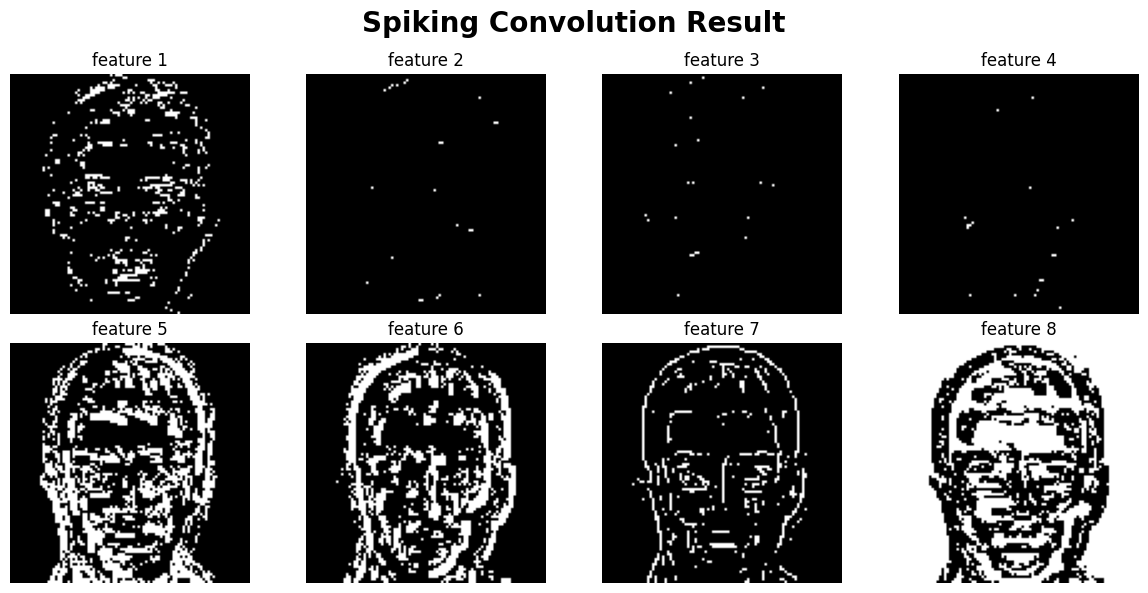

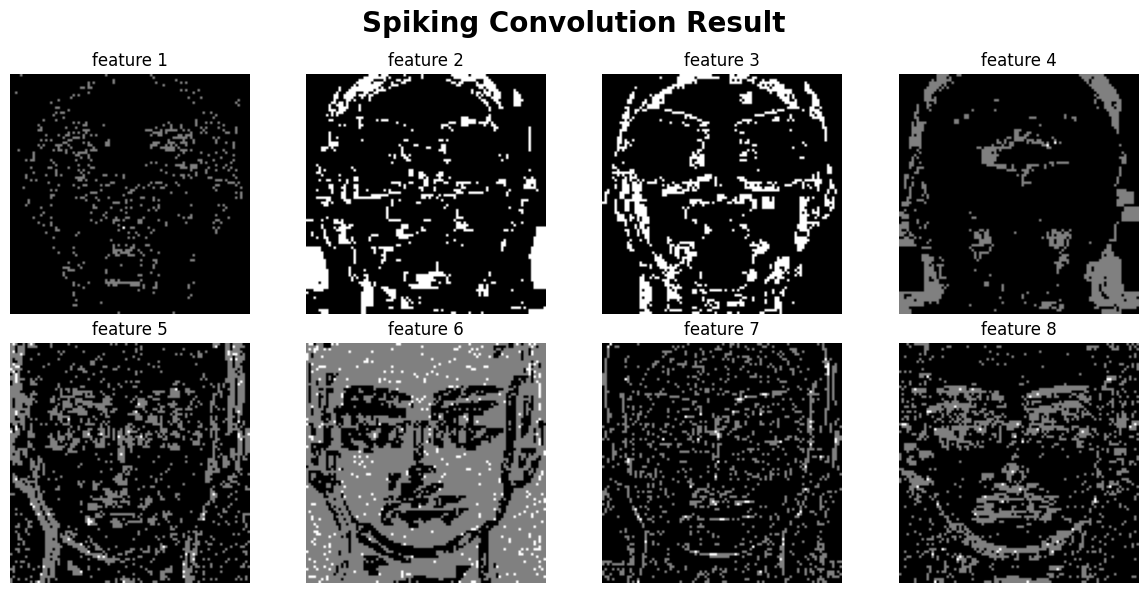

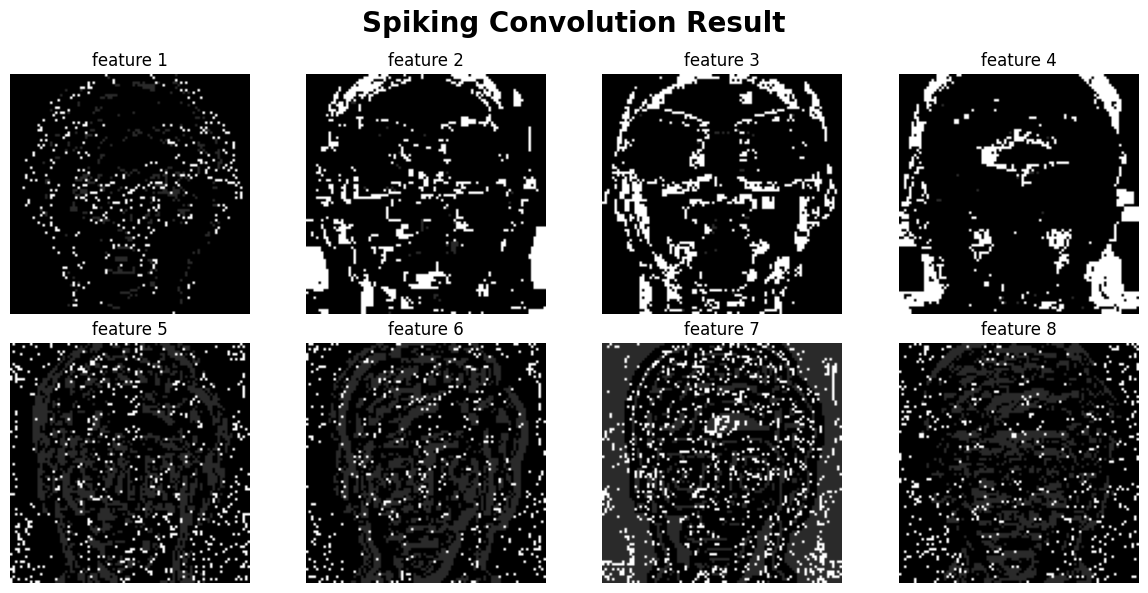

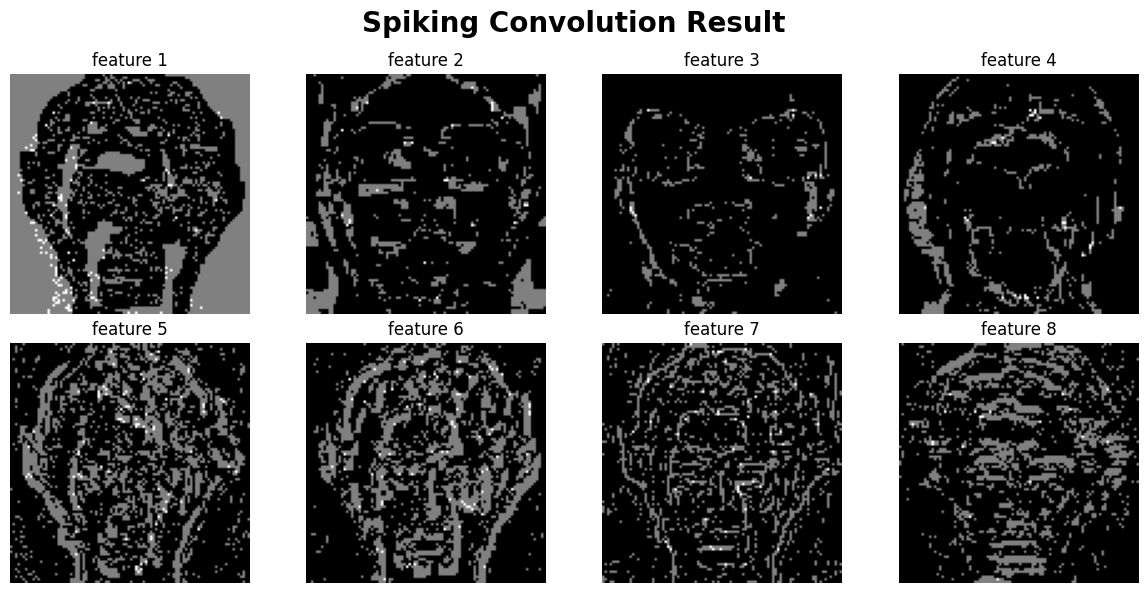

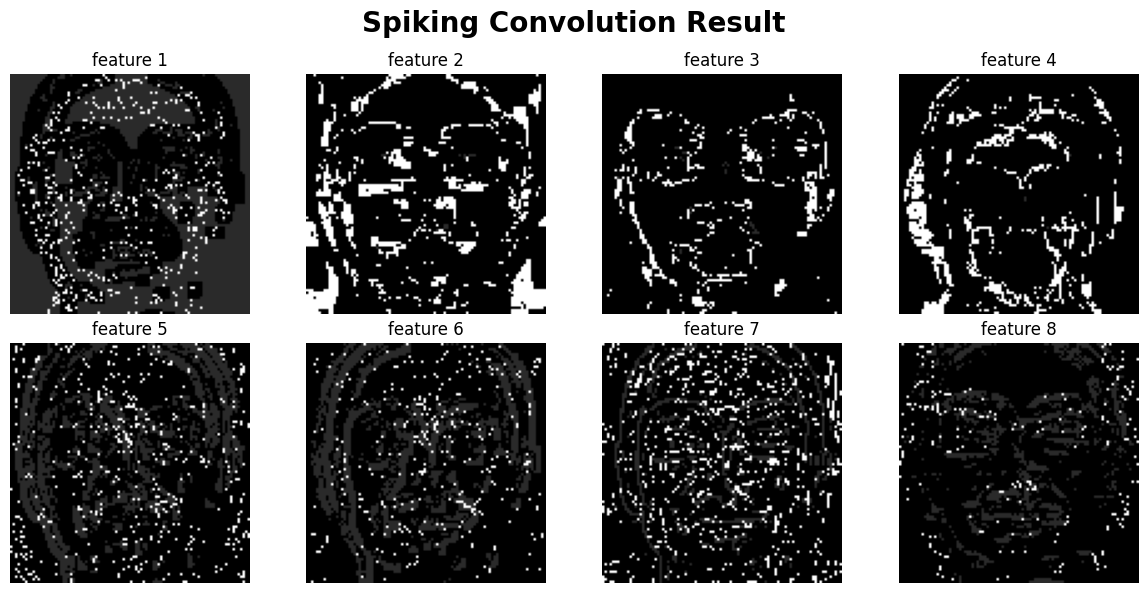

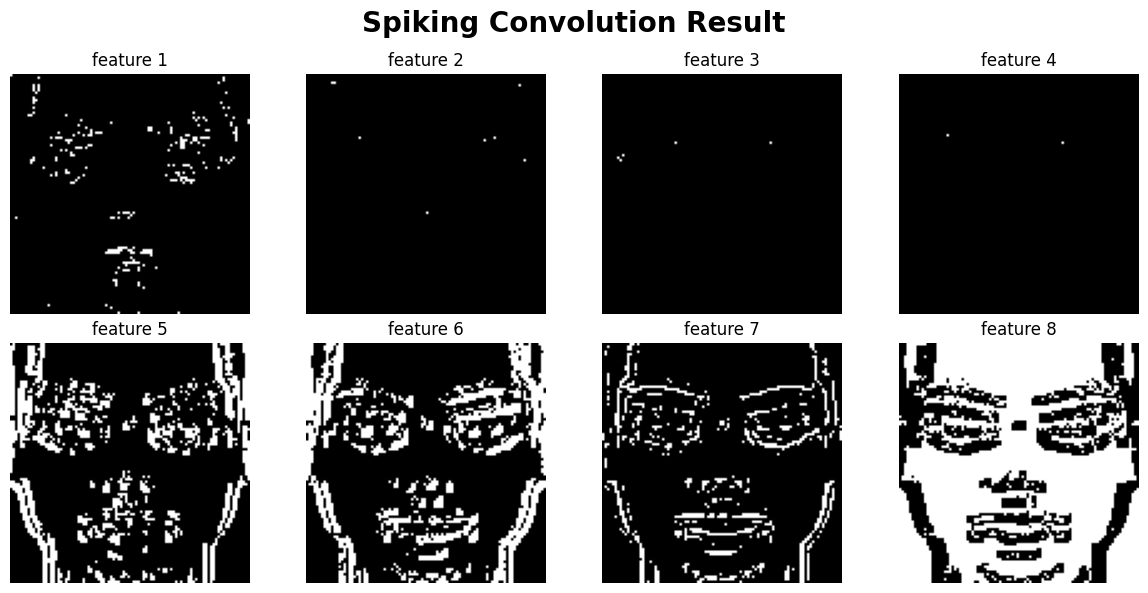

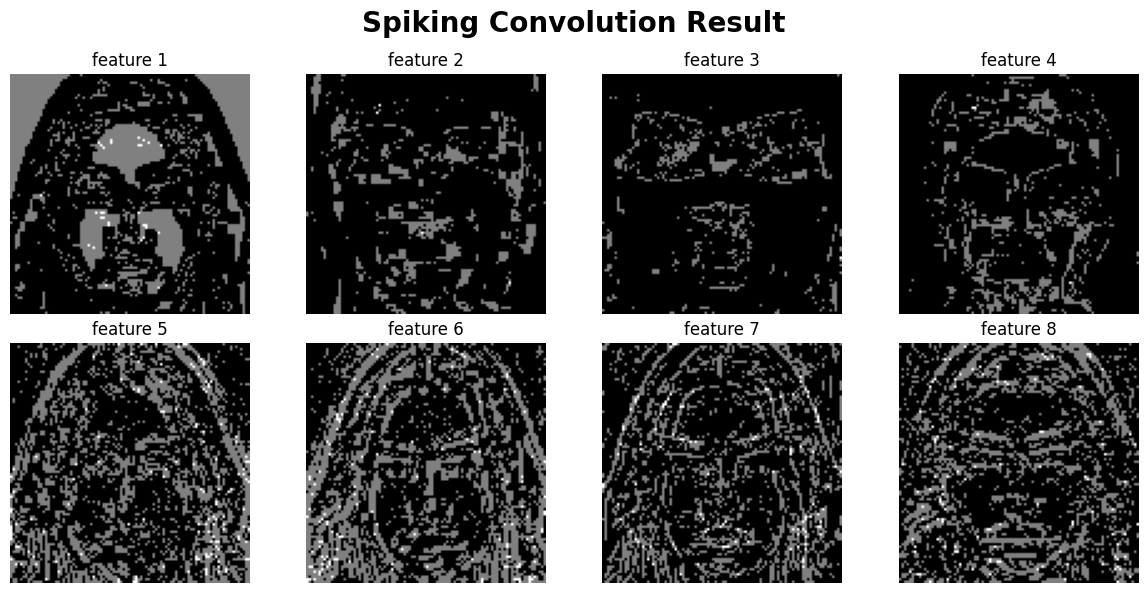

In [12]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=5,
    kernel_width=5,
    show_result_spike=True,
    show_last_spike=False,
    show_mean_spike=False,
    AP=5,
    AM=3.01,
    J_0_lateral=0
)

1000xBatch: 1/1 (100%) 28228.817ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


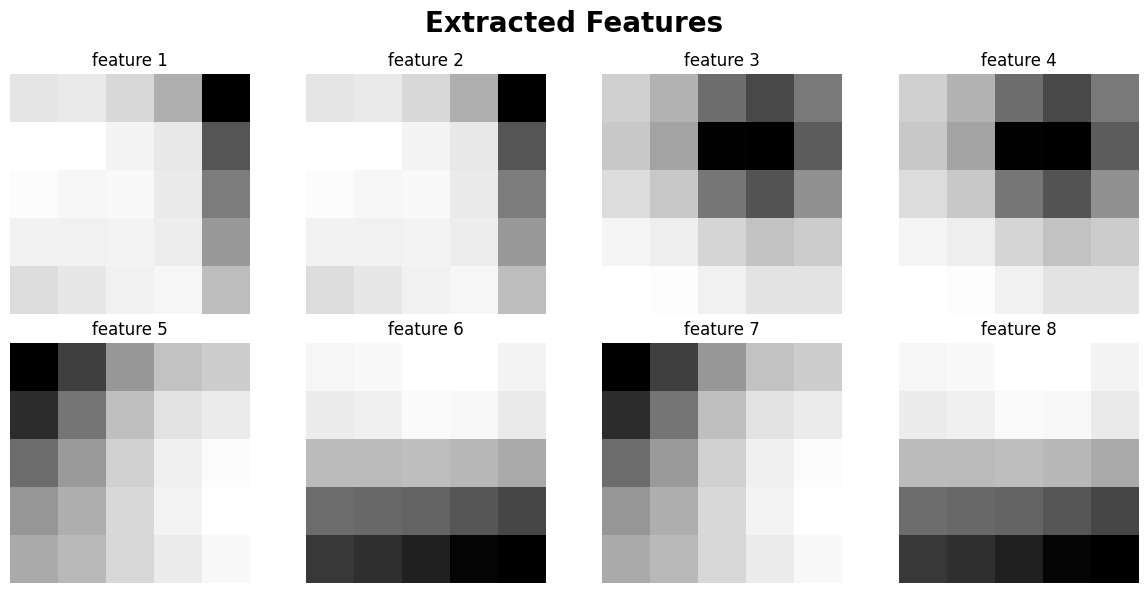

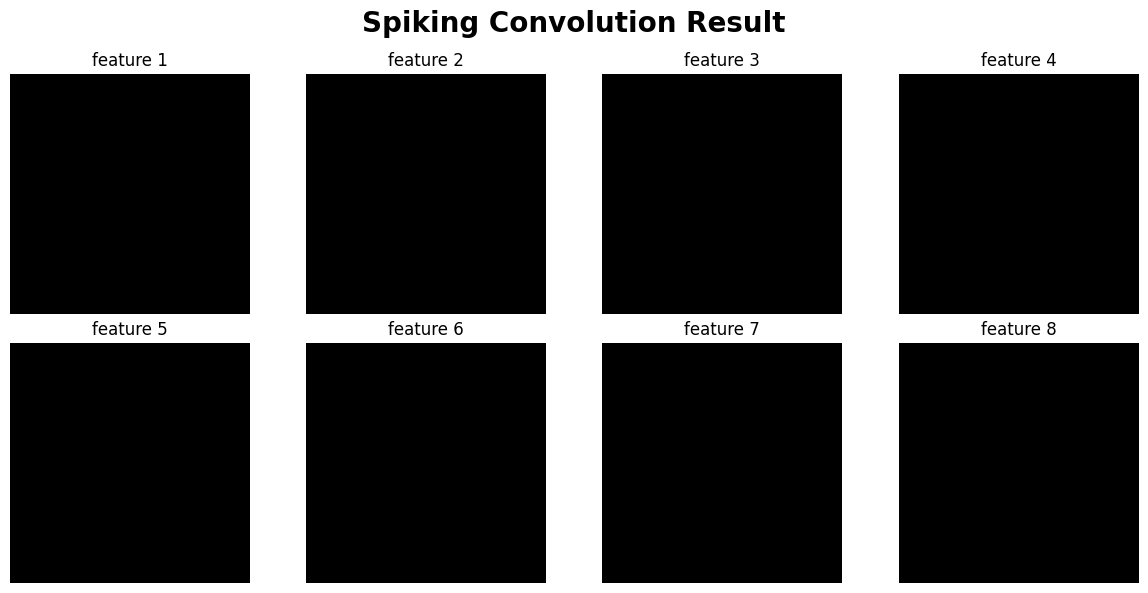

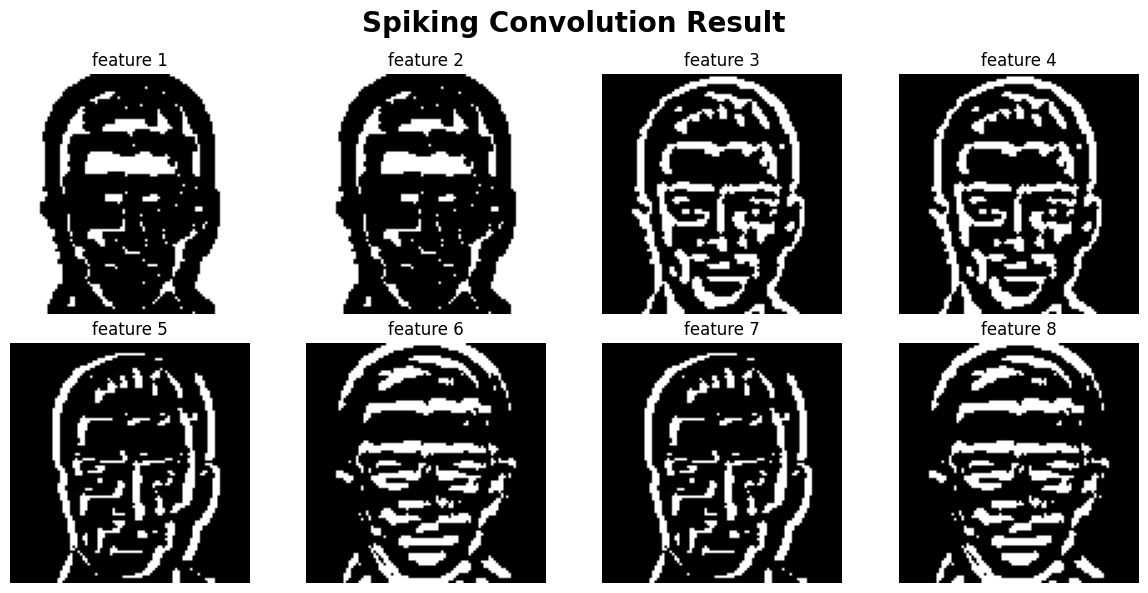

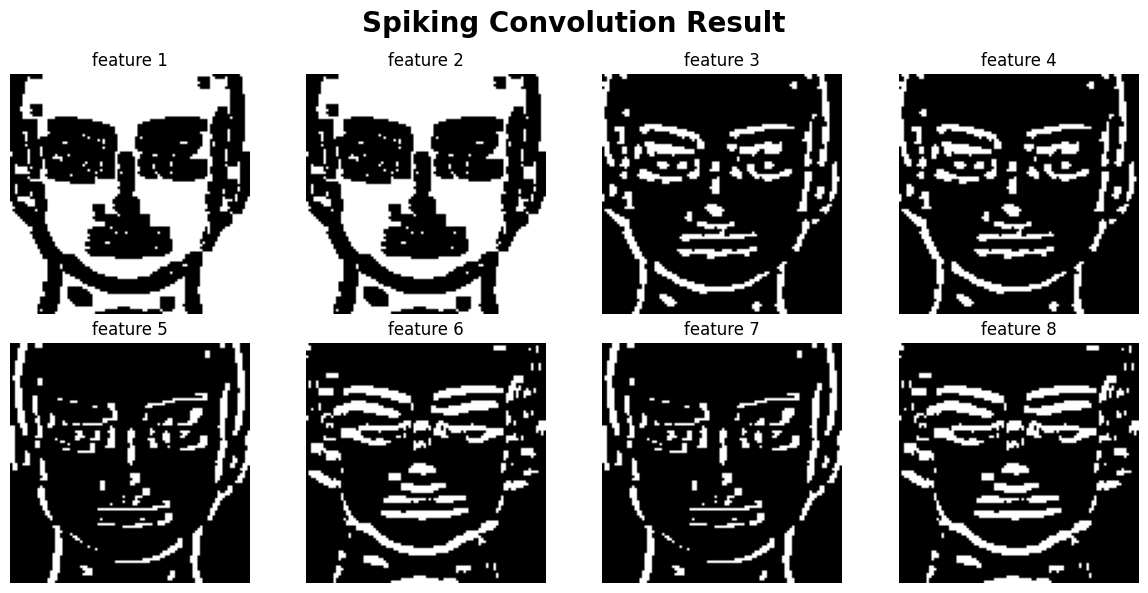

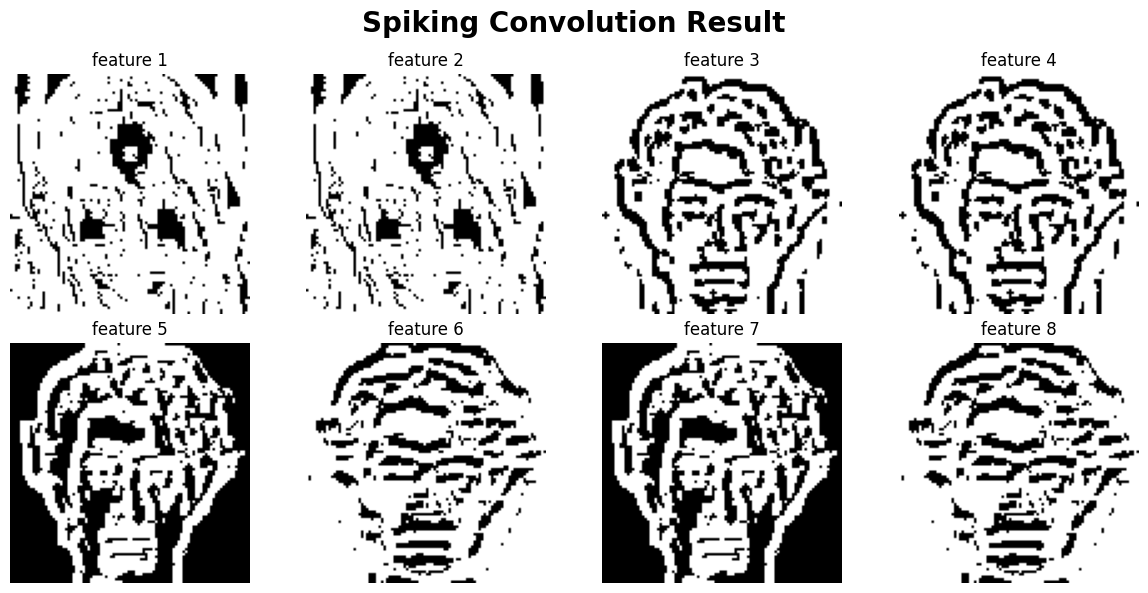

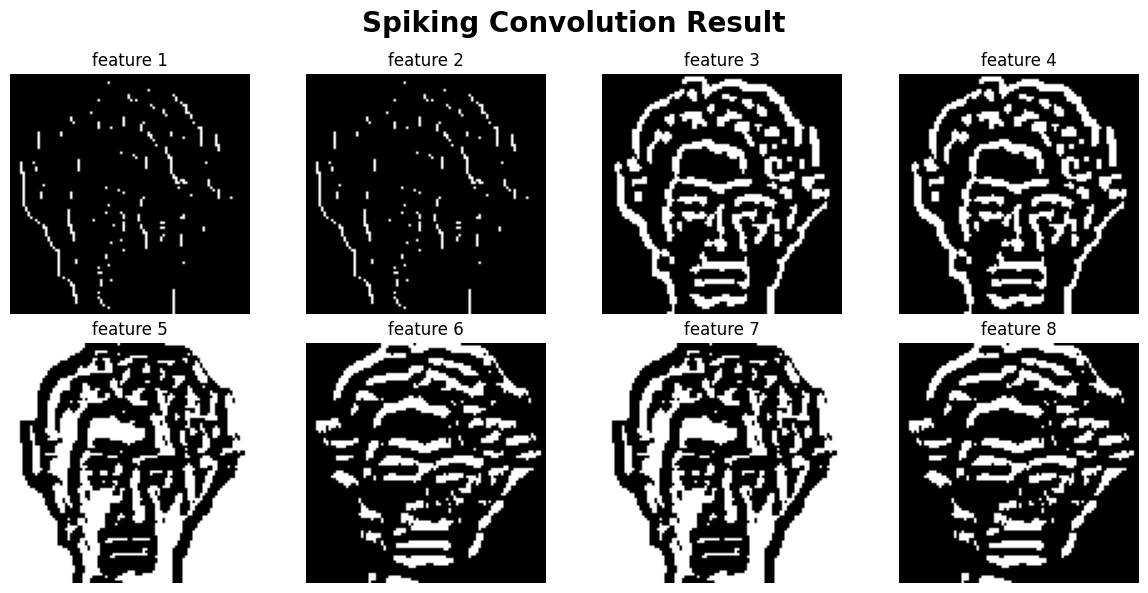

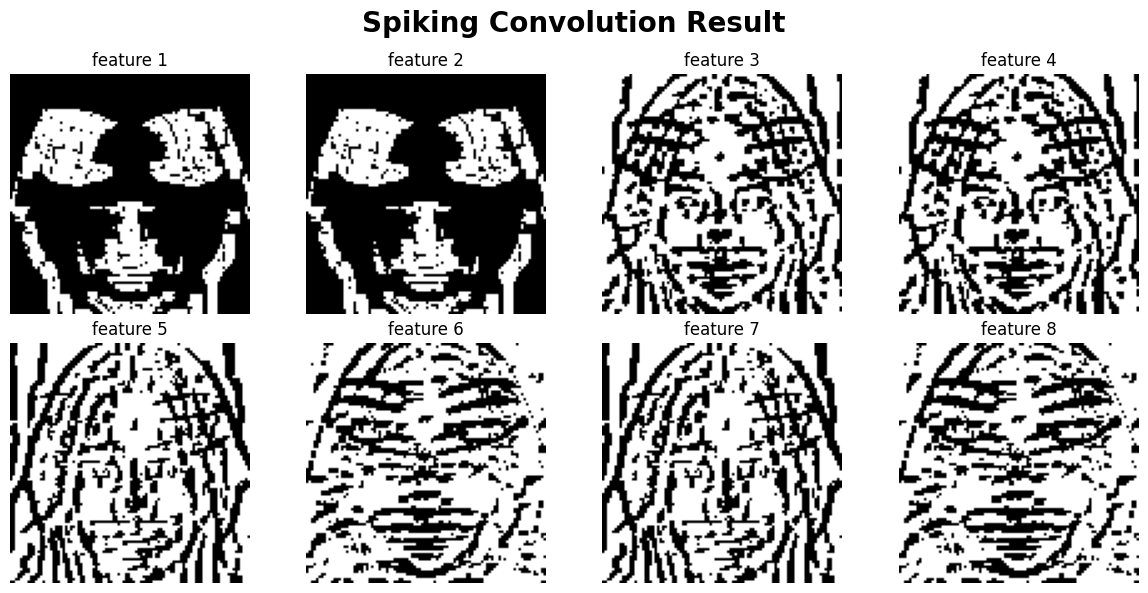

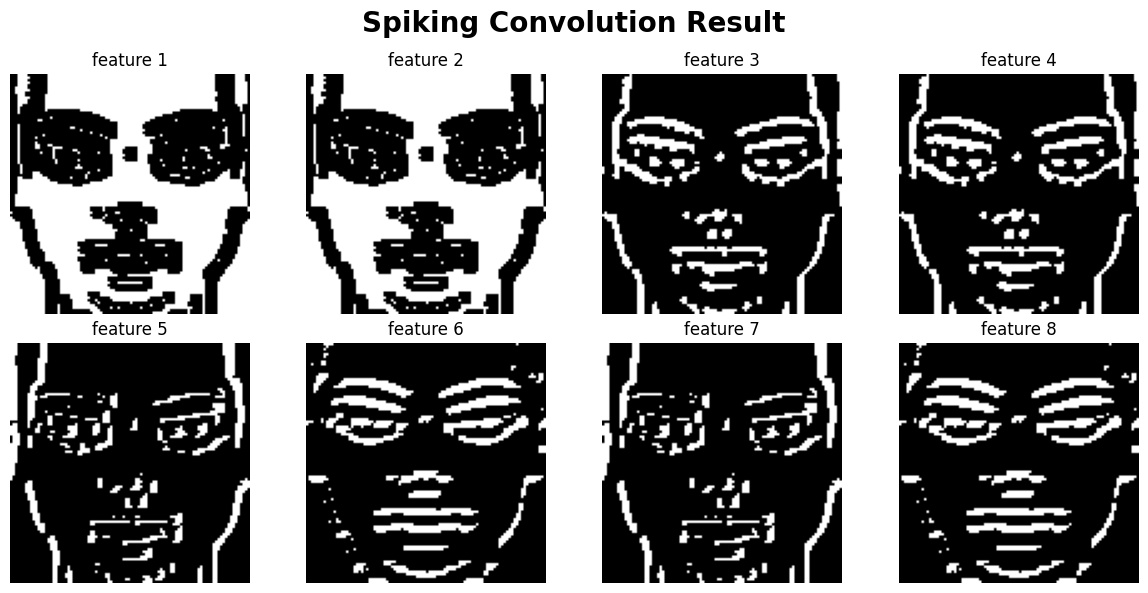

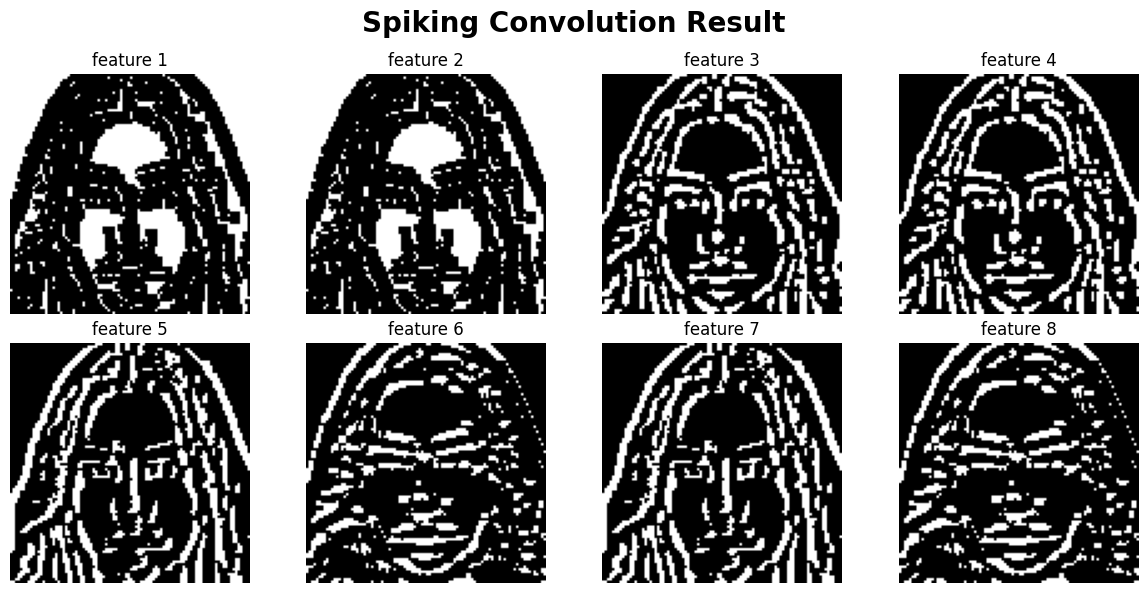

In [226]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=5,
    kernel_width=5,
    show_result_spike=True,
    show_last_spike=False,
    show_mean_spike=False,
    AP=5,
    AM=3.01,
    K=2,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 21938.188ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


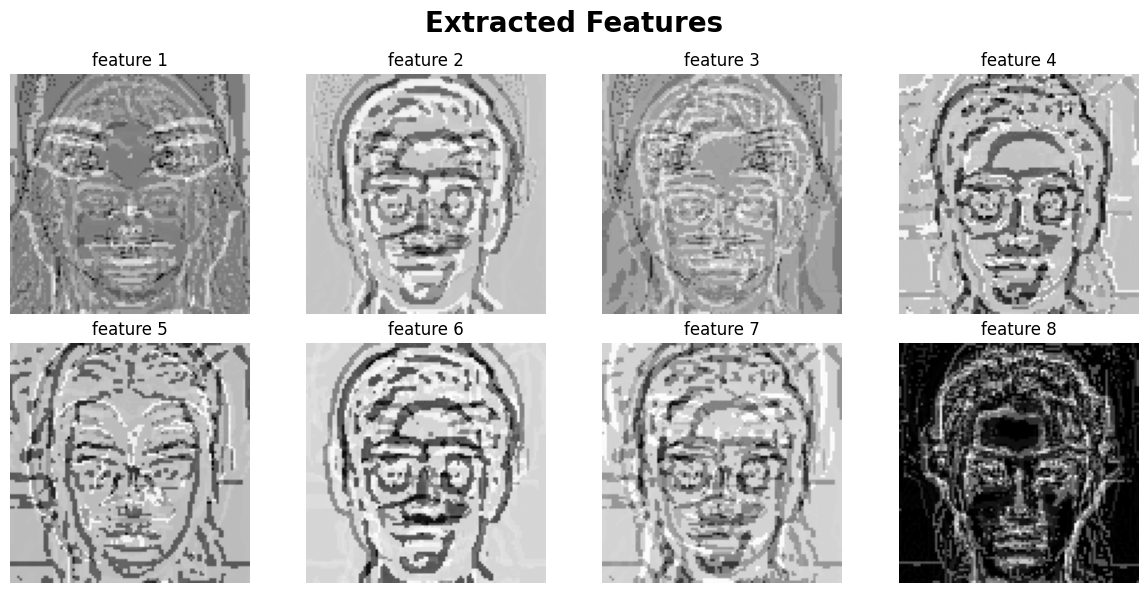

In [217]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.1,
    rest_time=5,
    window_siz=2,
    kernel_height=100,
    kernel_width=100,
    show_result_spike=False,
    show_last_spike=False,
    show_mean_spike=False,
    AP=0.99999,
    AM=0.00001,
)

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=15,
    kernel_width=15,
    show_result_spike=False,
    show_last_spike=False,
    show_mean_spike=False,
    AP=1,
    AM=0.5,)

In [ ]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=21,
    kernel_width=21,
    show_result_spike=False,
    show_last_spike=False,
    show_mean_spike=False,
    AP=3,
    AM=0.5,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 27816.600ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


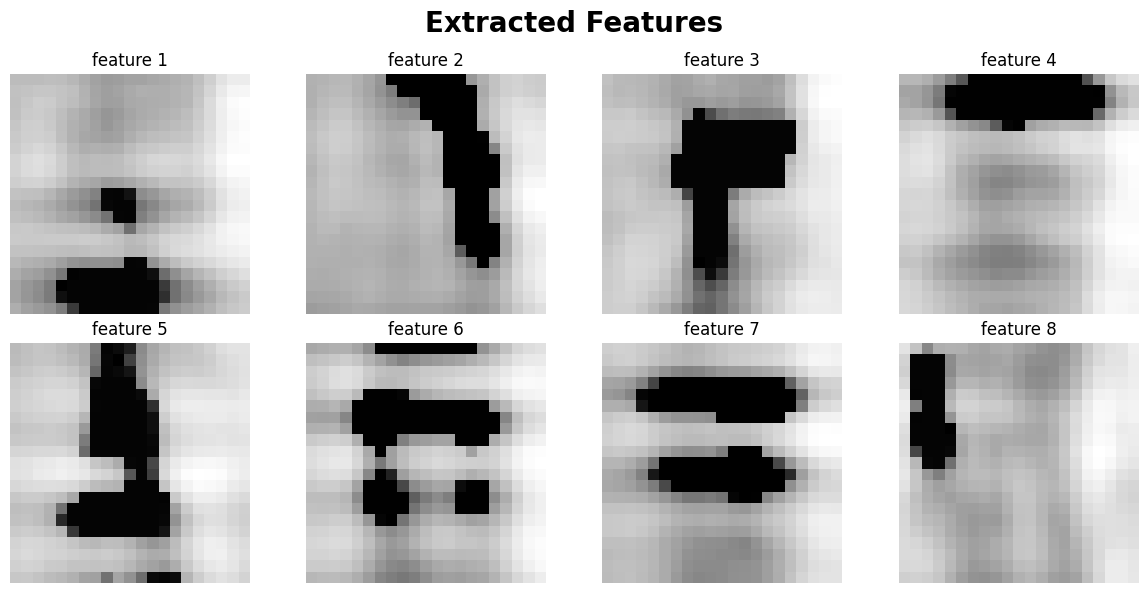

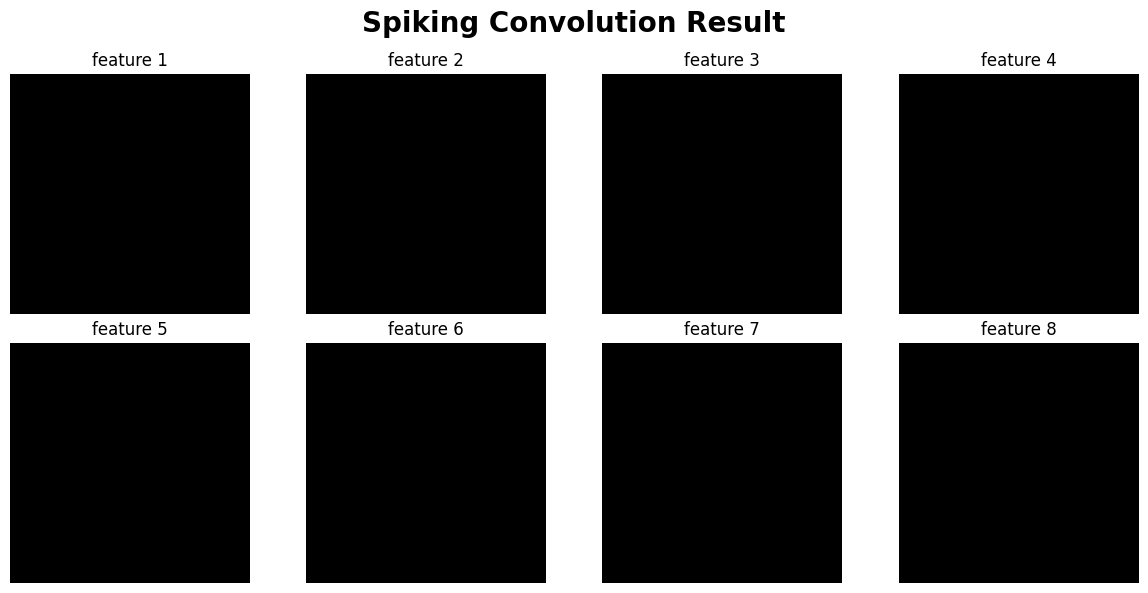

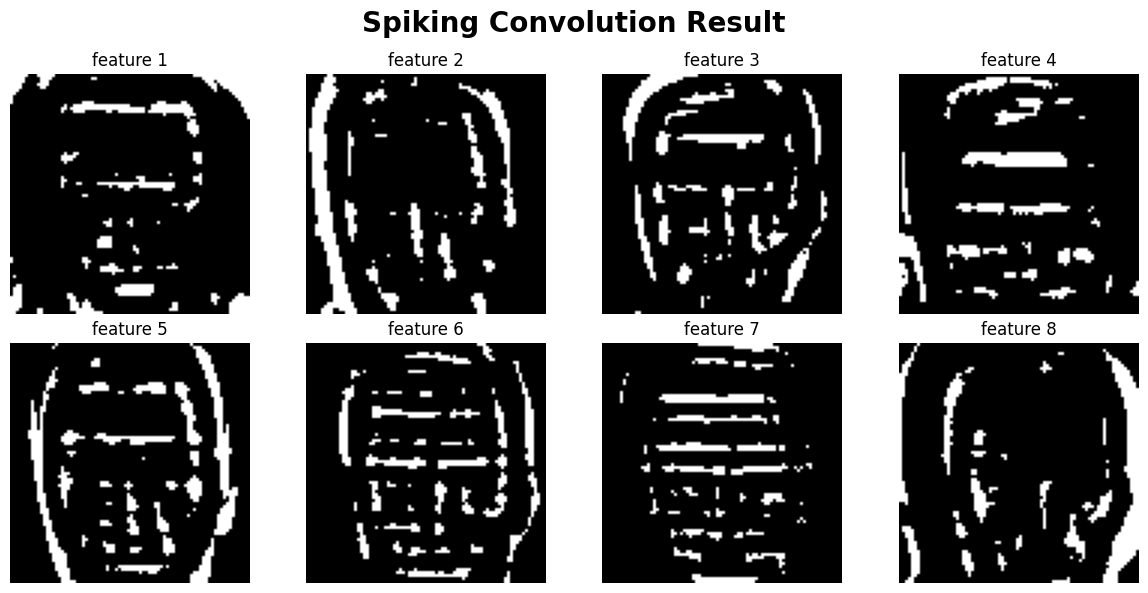

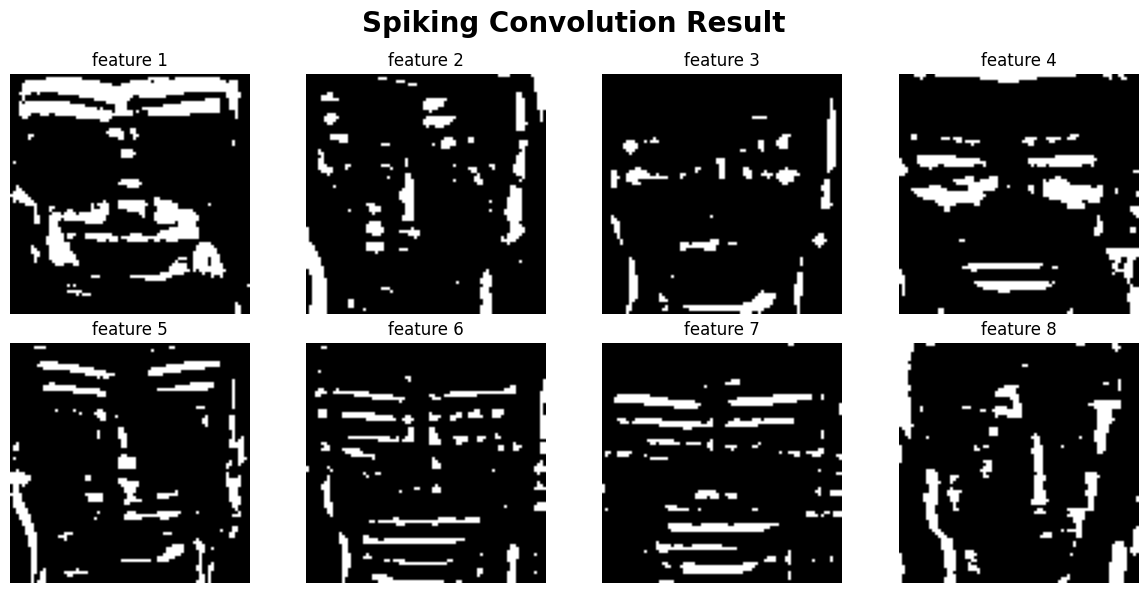

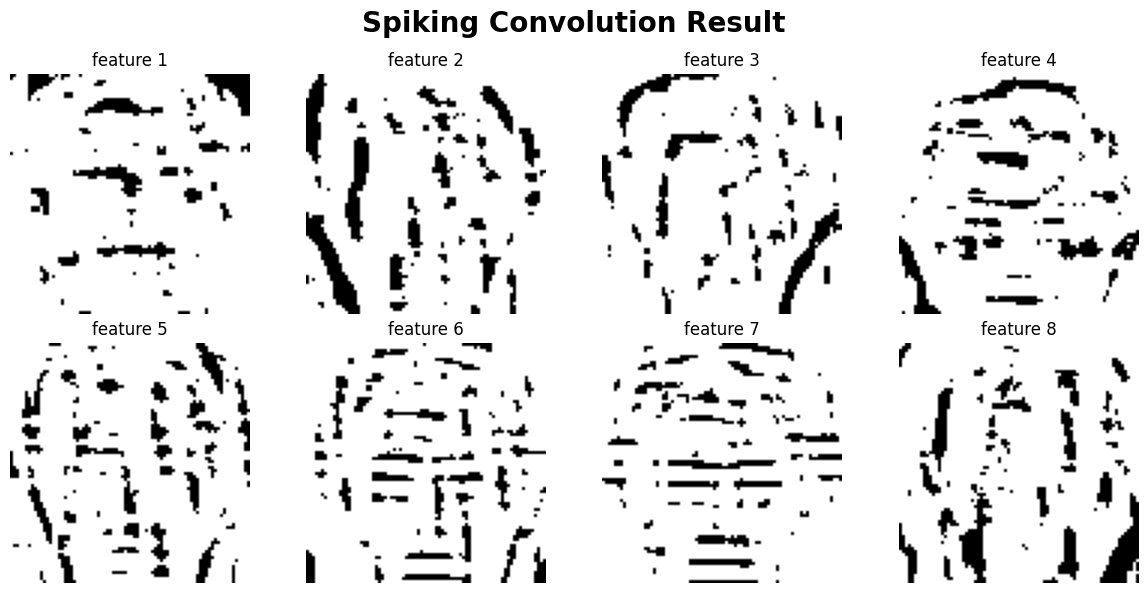

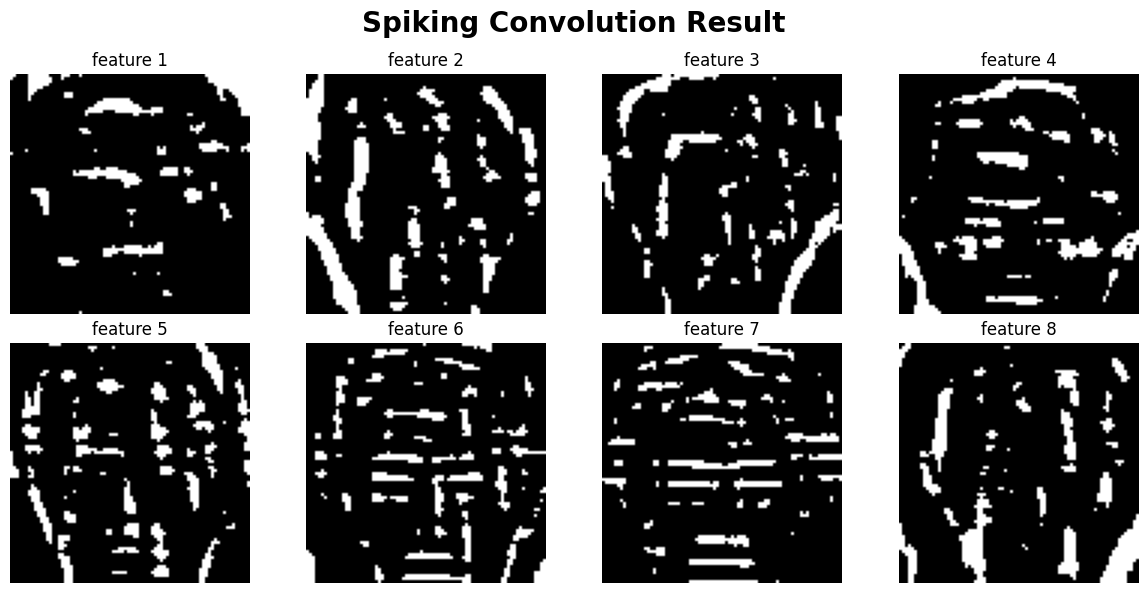

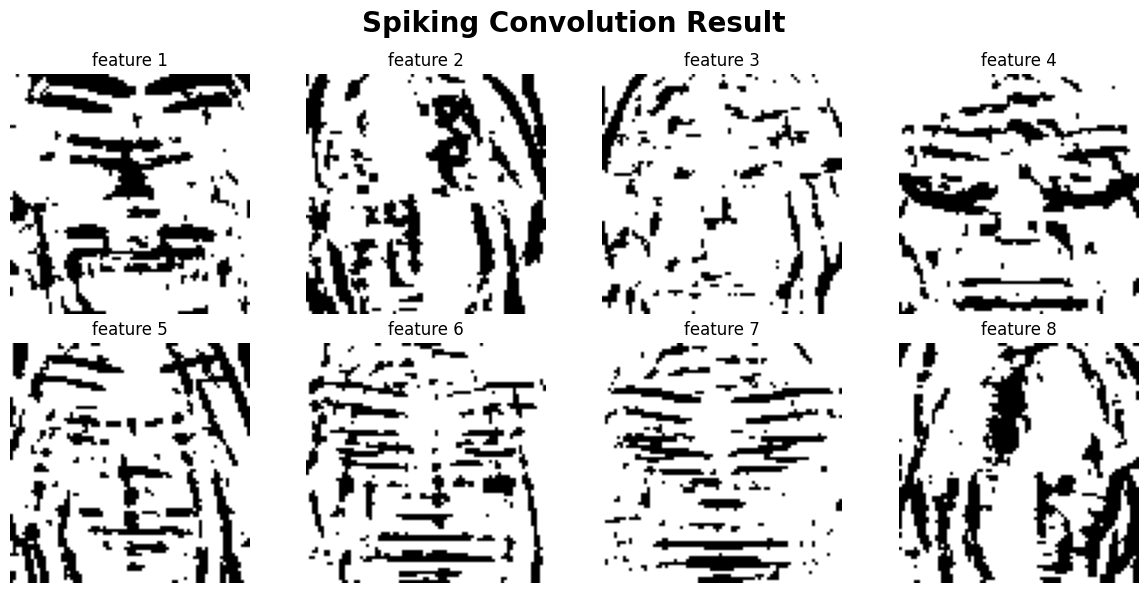

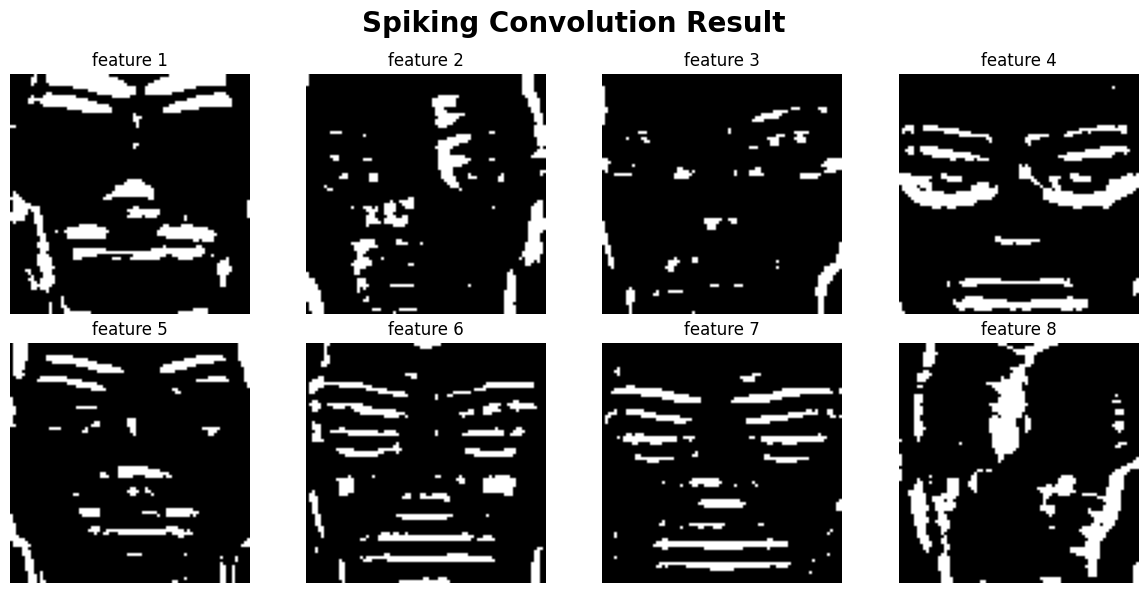

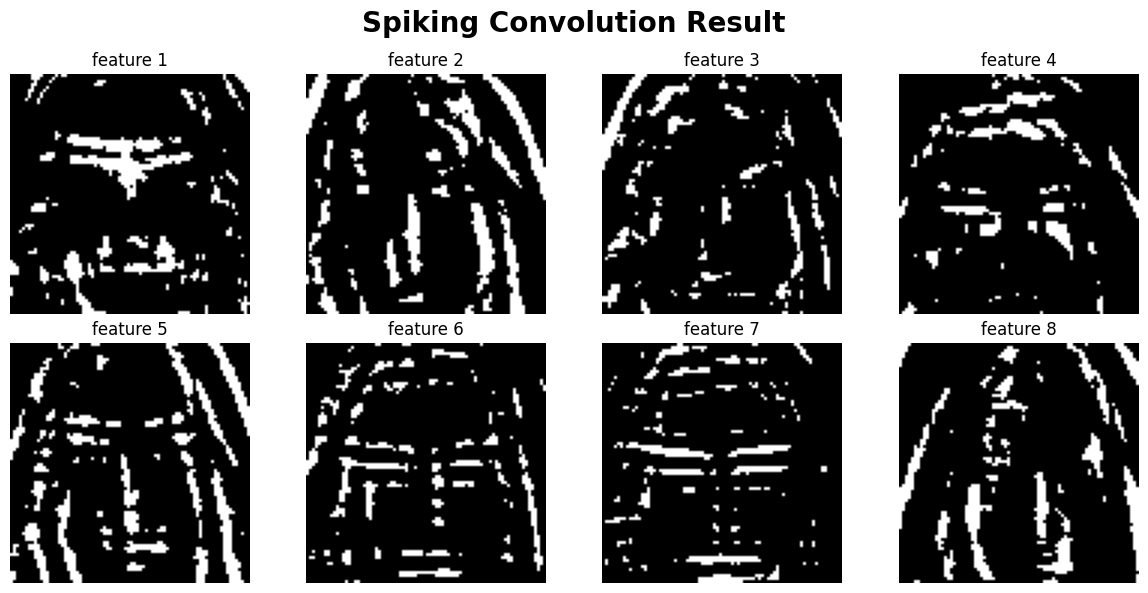

In [223]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=21,
    kernel_width=21,
    show_result_spike=True,
    show_last_spike=False,
    show_mean_spike=False,
    AP=5,
    AM=3.01,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 29411.647ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


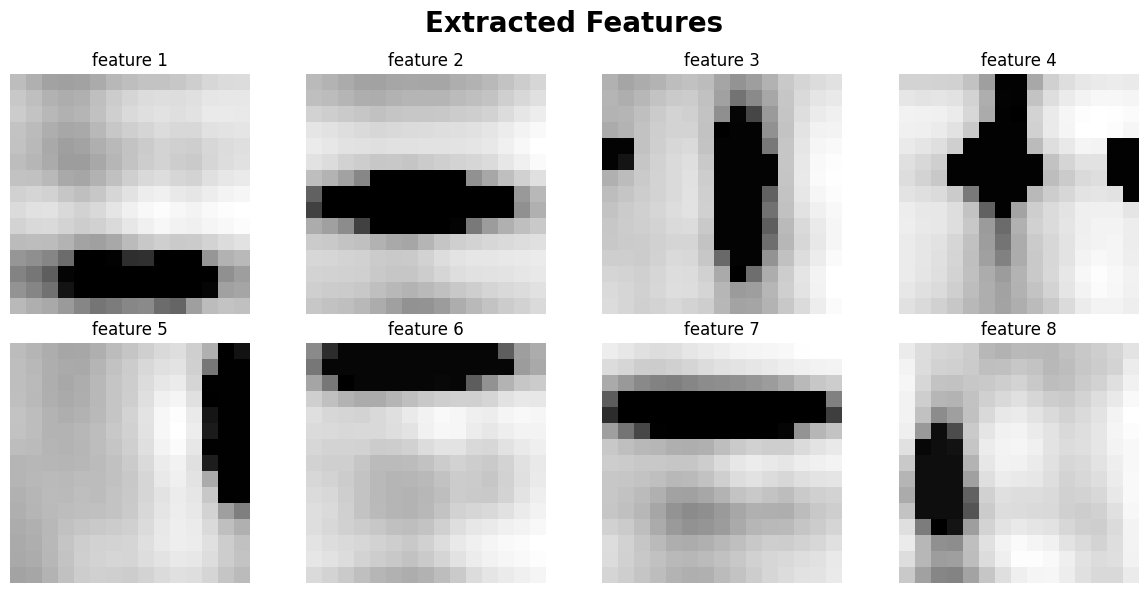

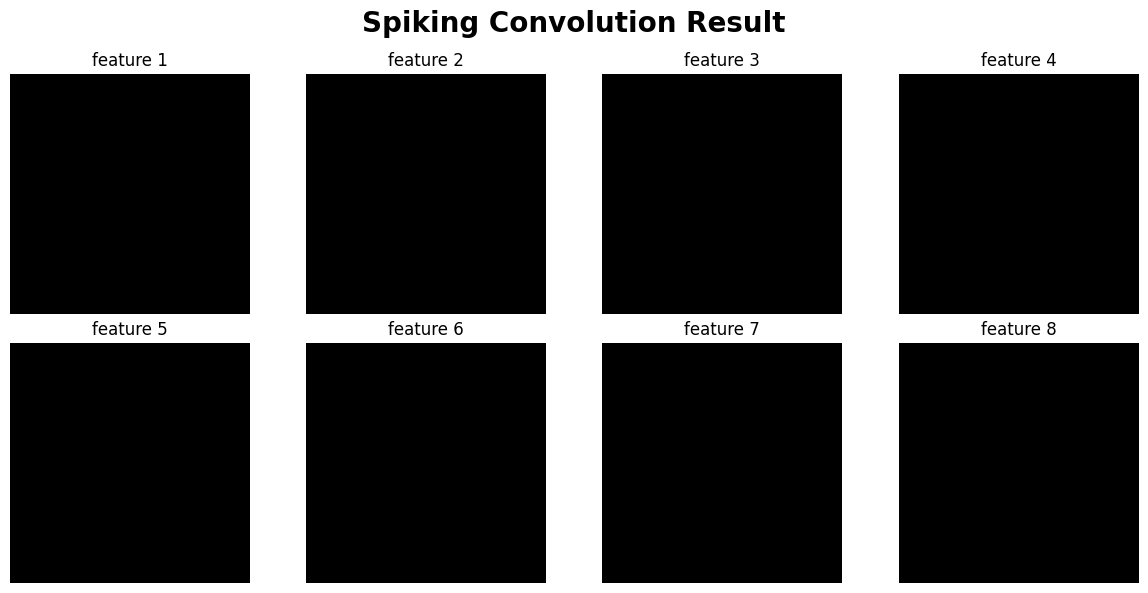

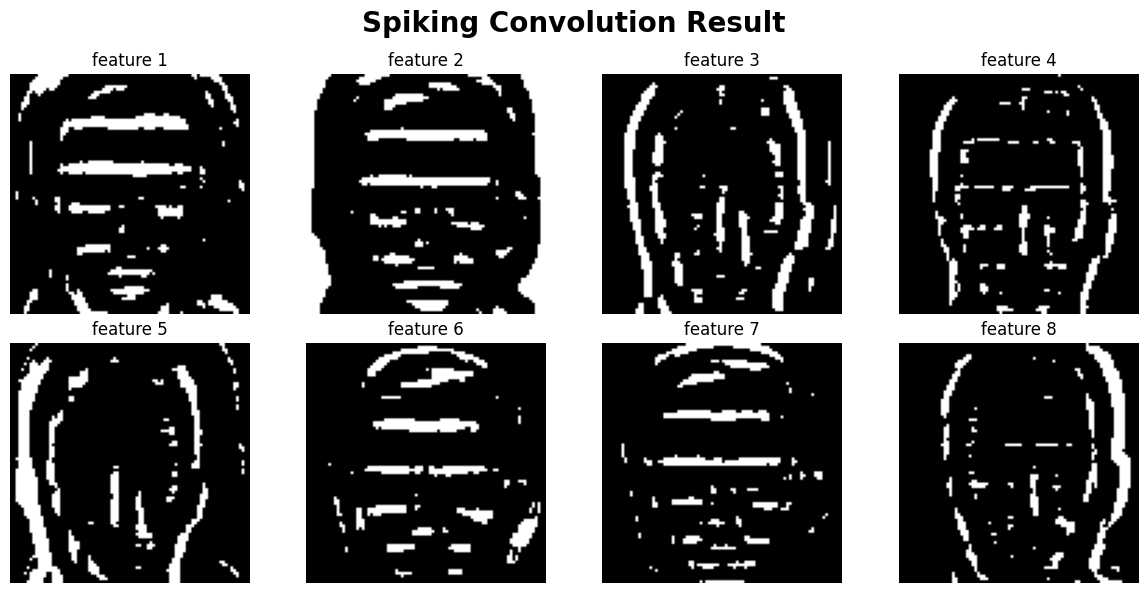

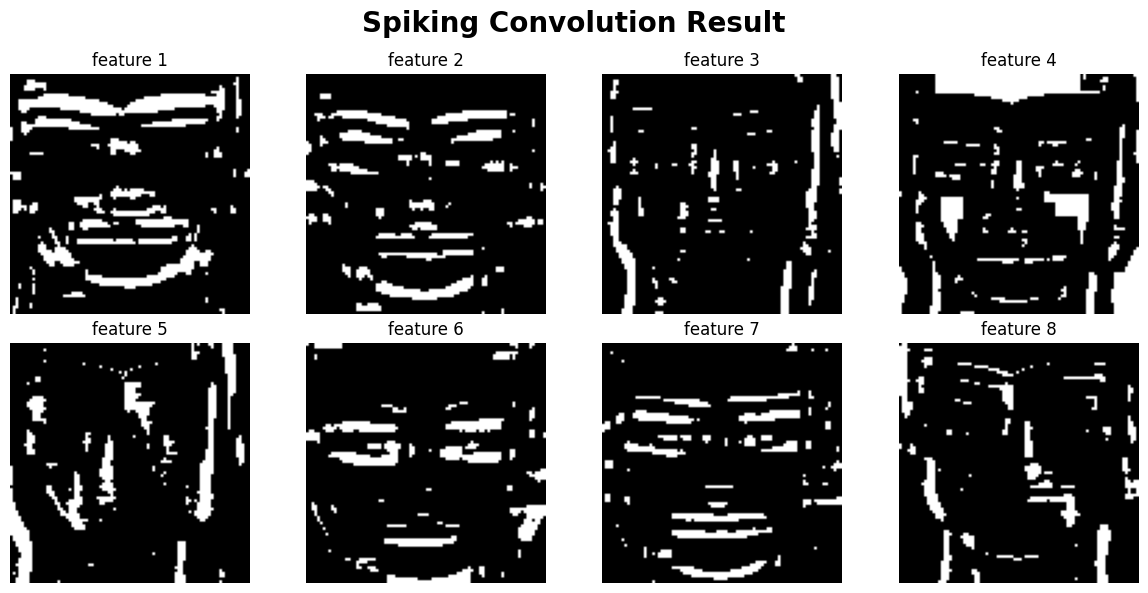

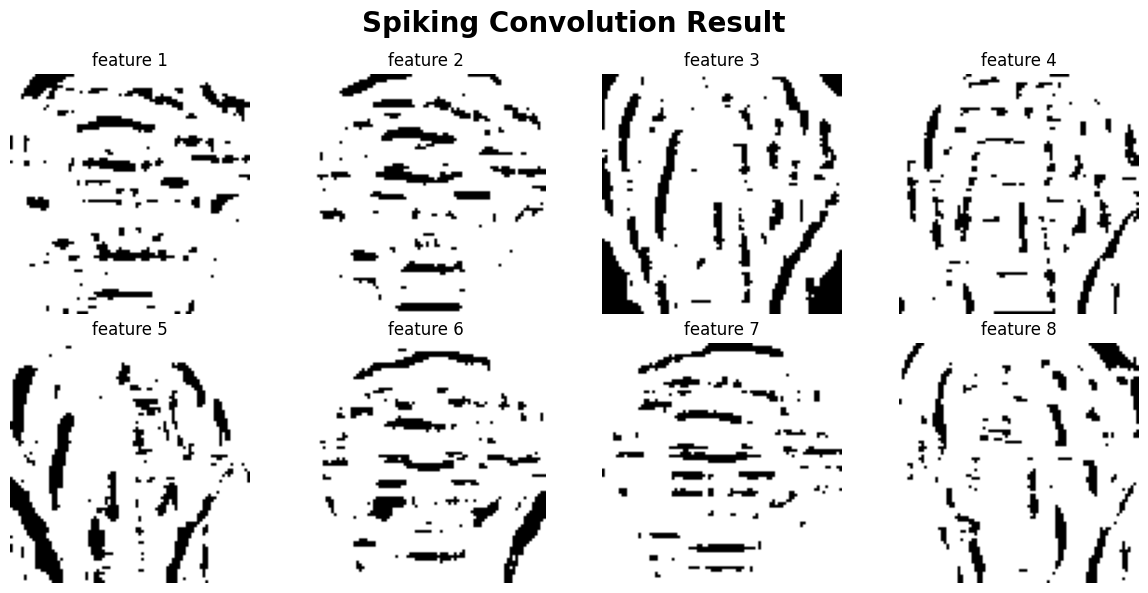

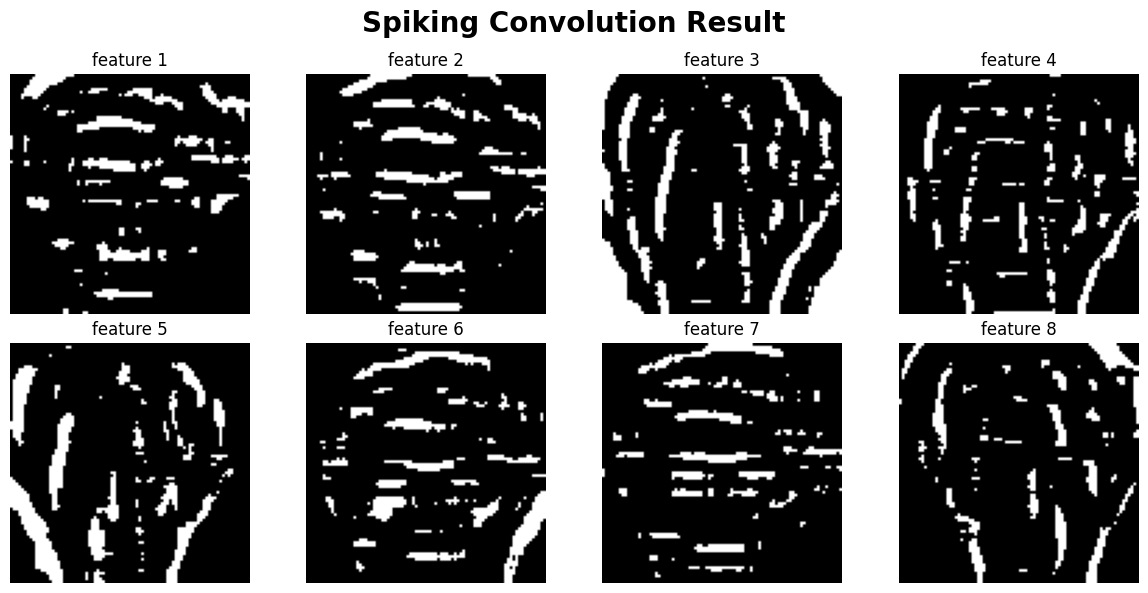

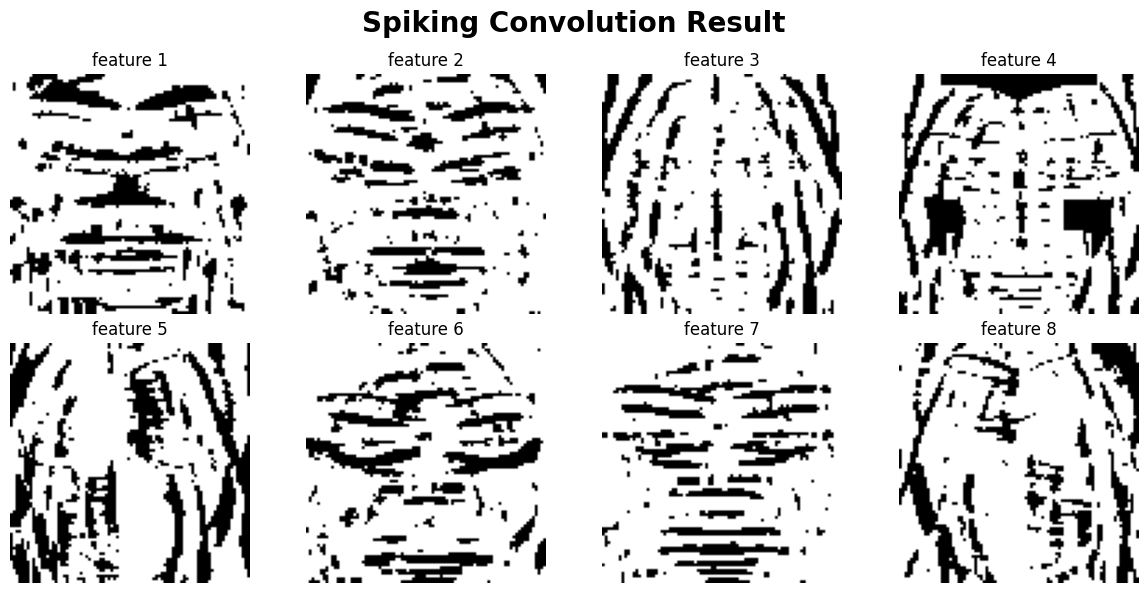

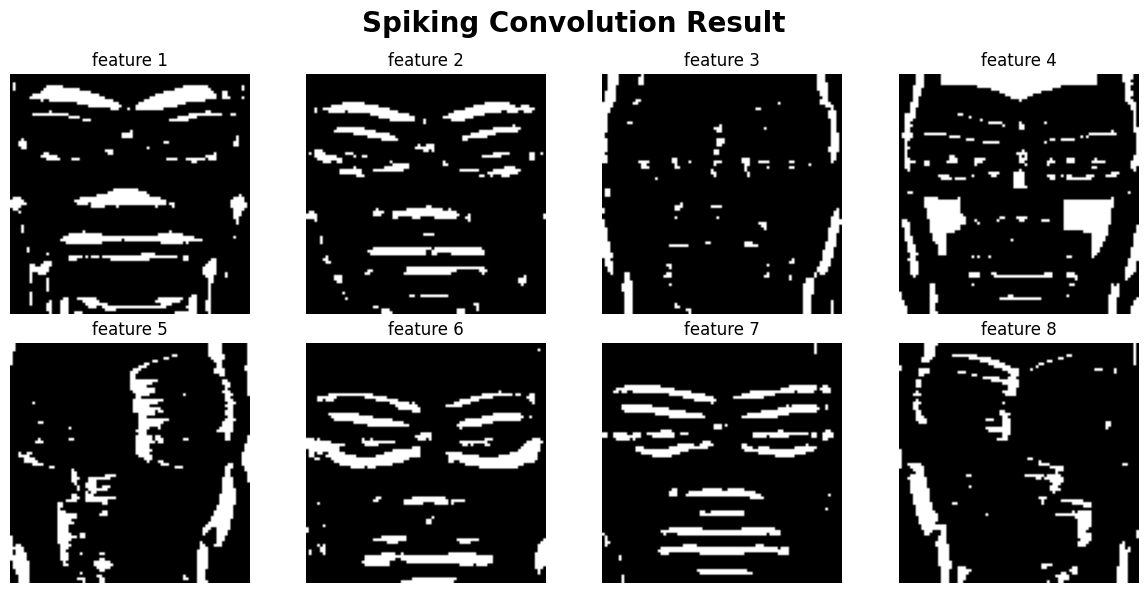

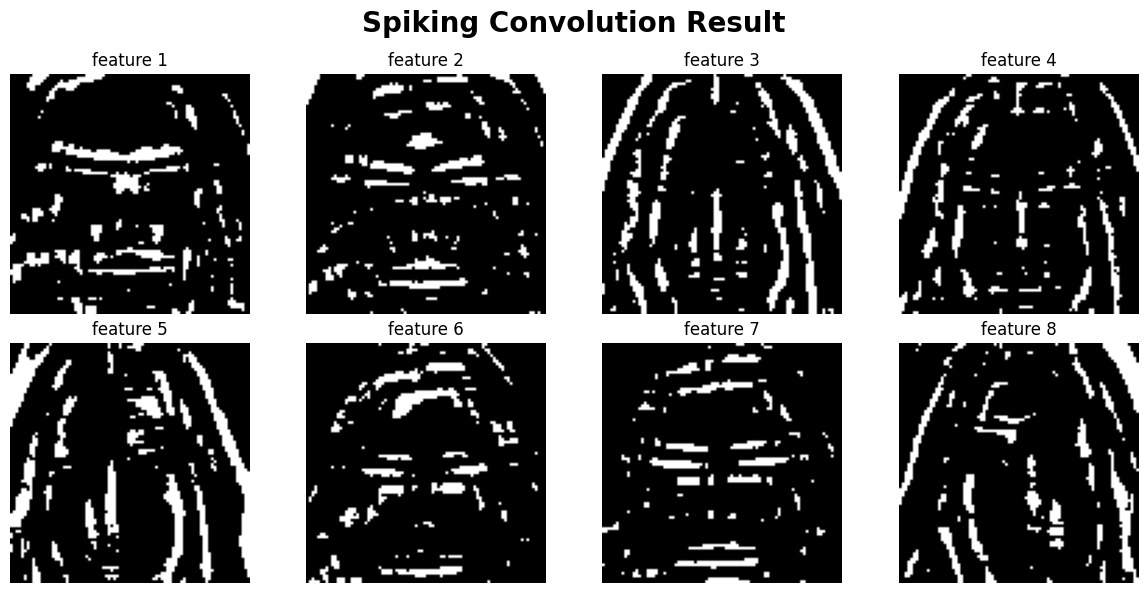

In [222]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=15,
    kernel_width=15,
    show_result_spike=True,
    show_last_spike=False,
    show_mean_spike=False,
    AP=5,
    AM=3.01,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 28384.657ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


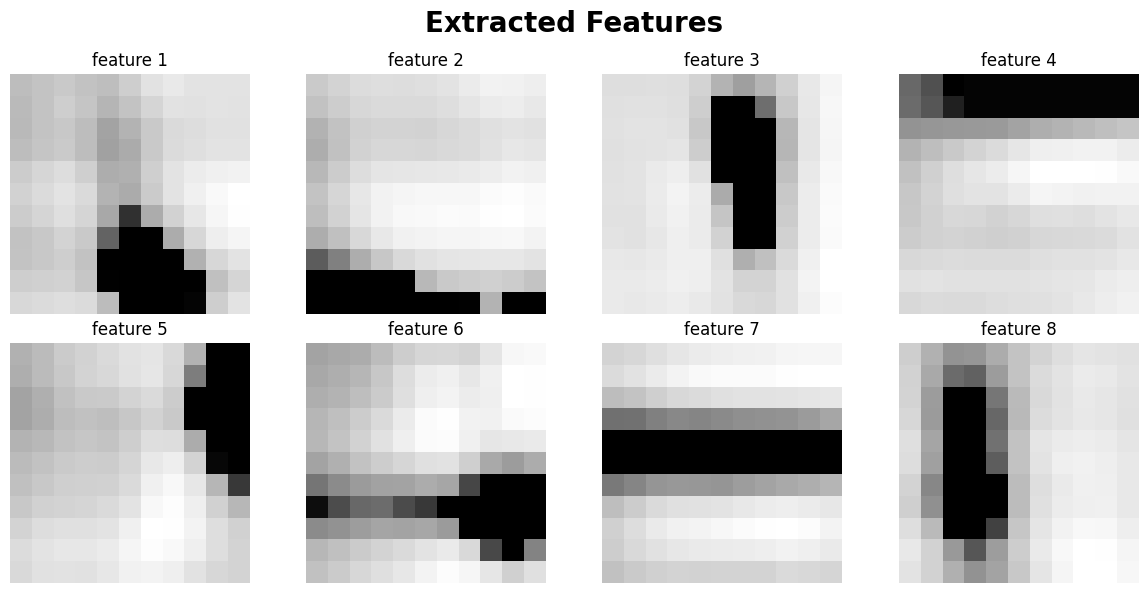

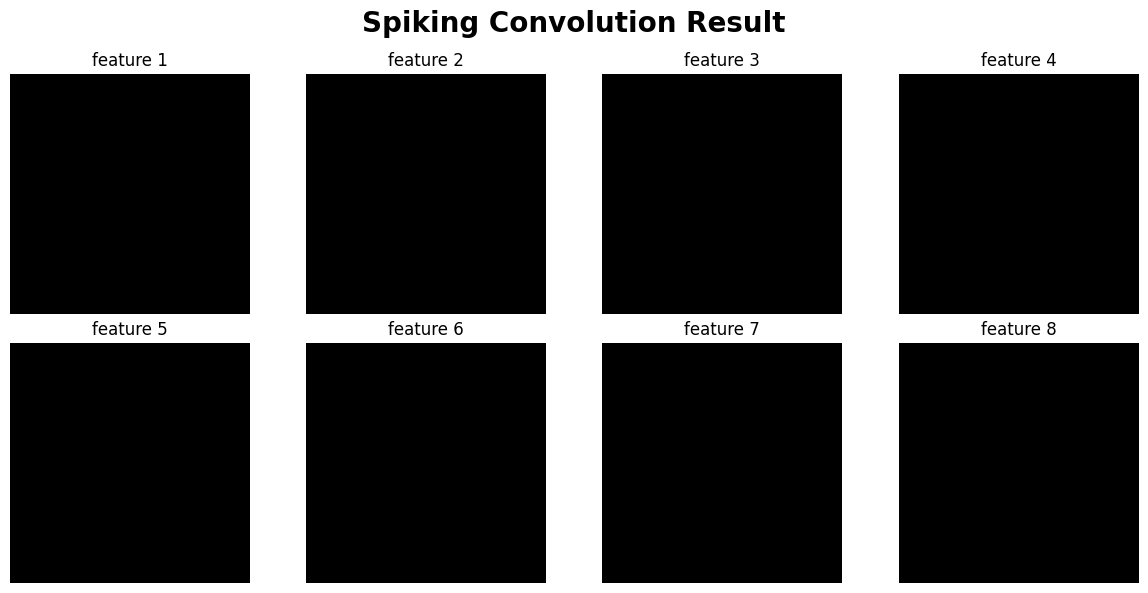

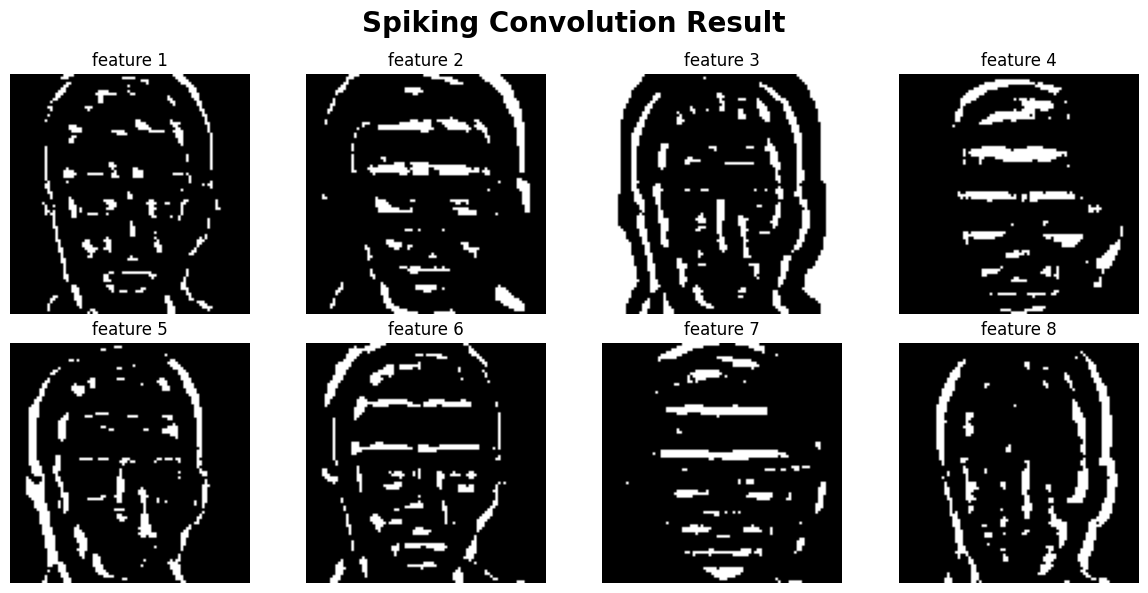

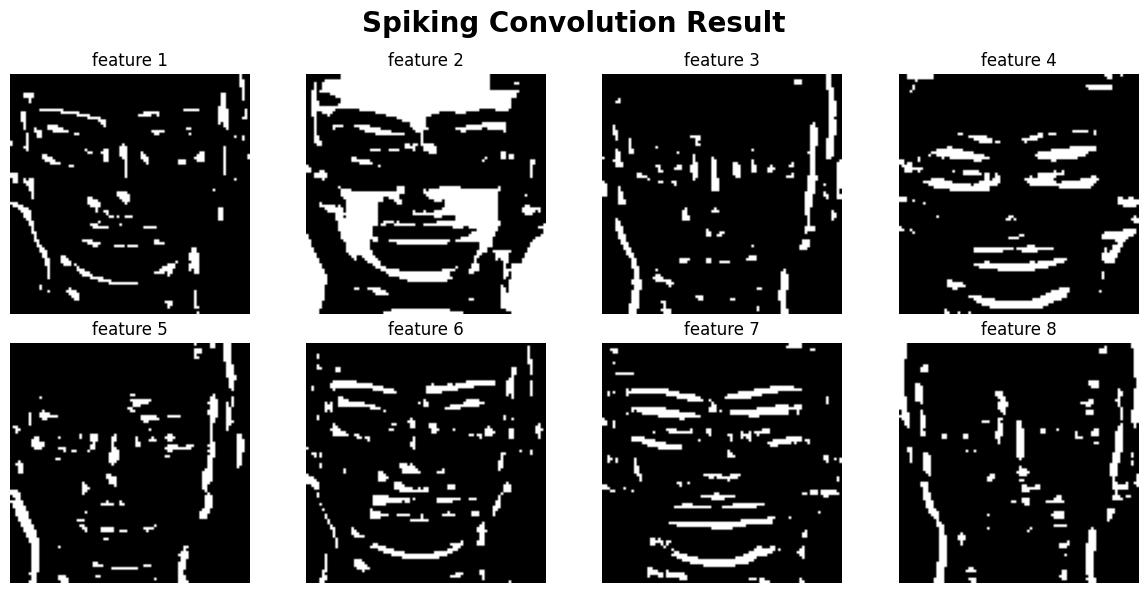

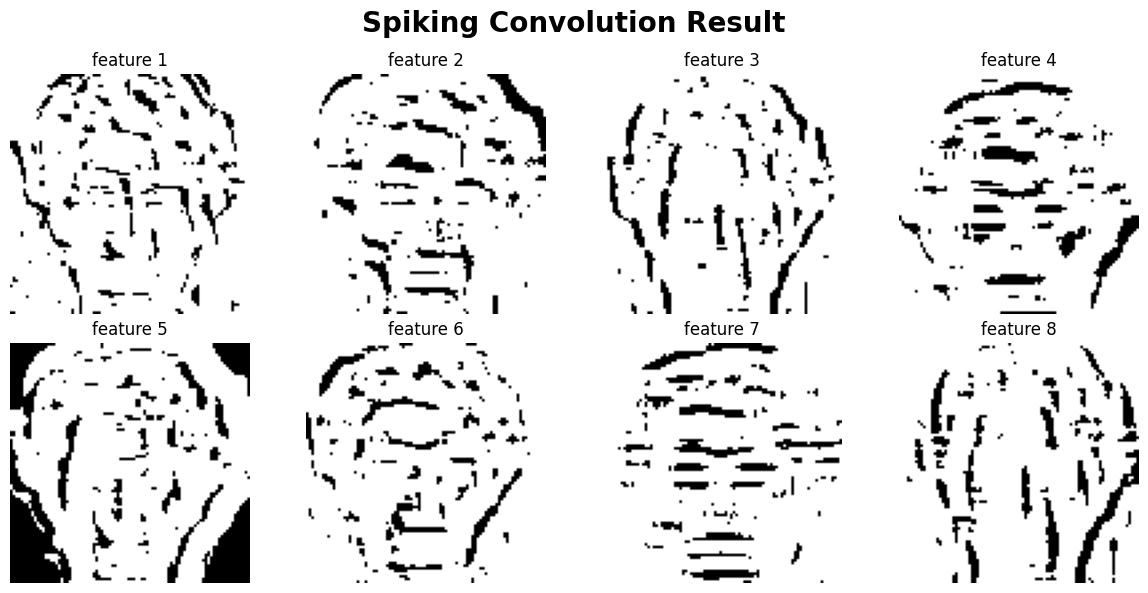

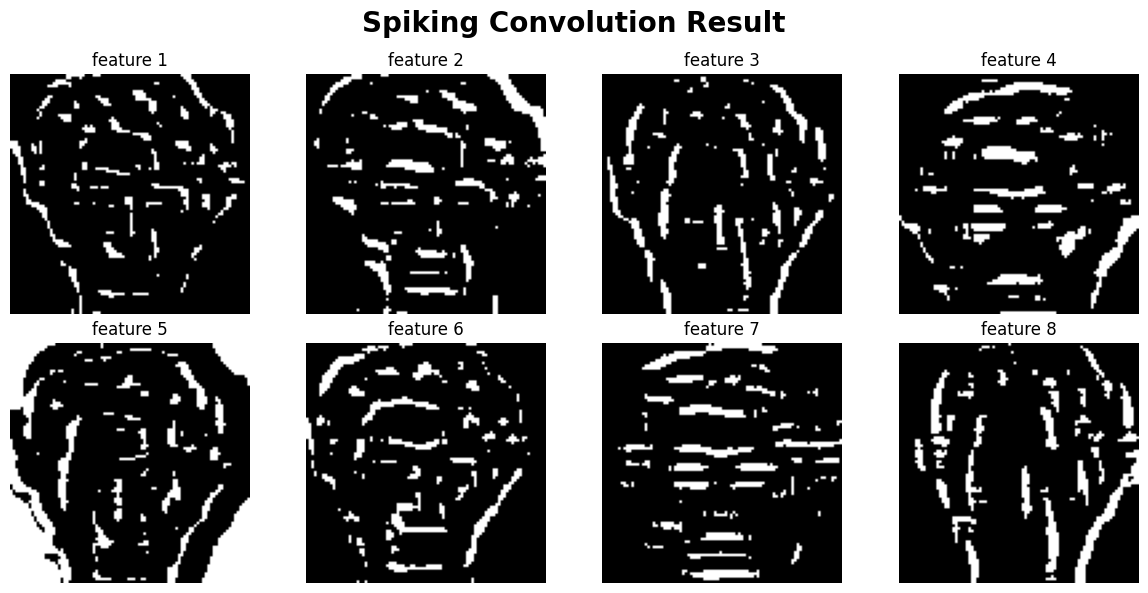

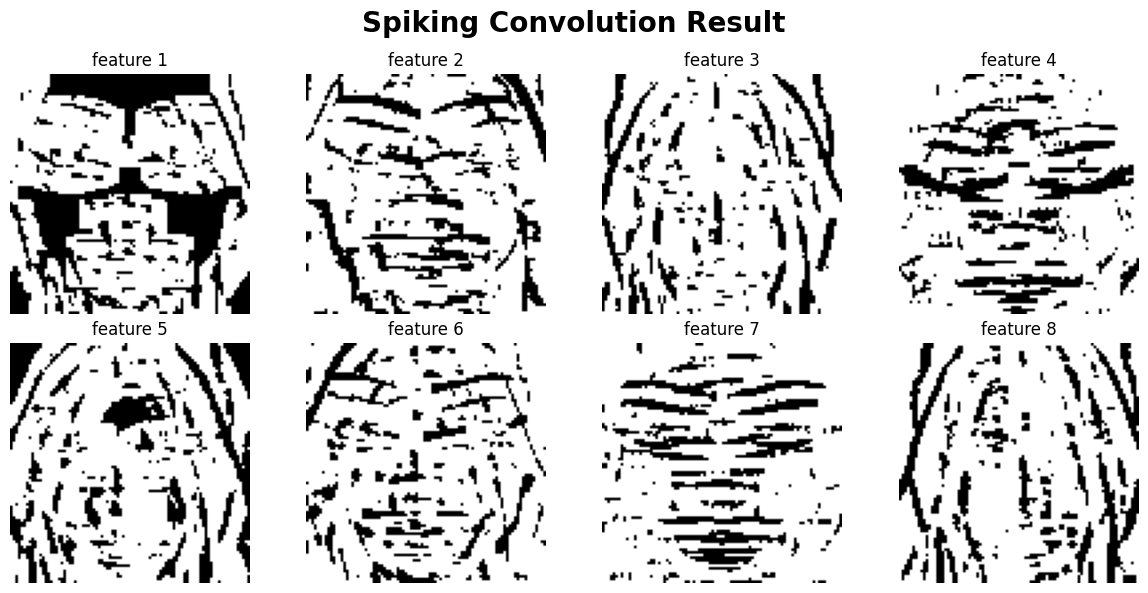

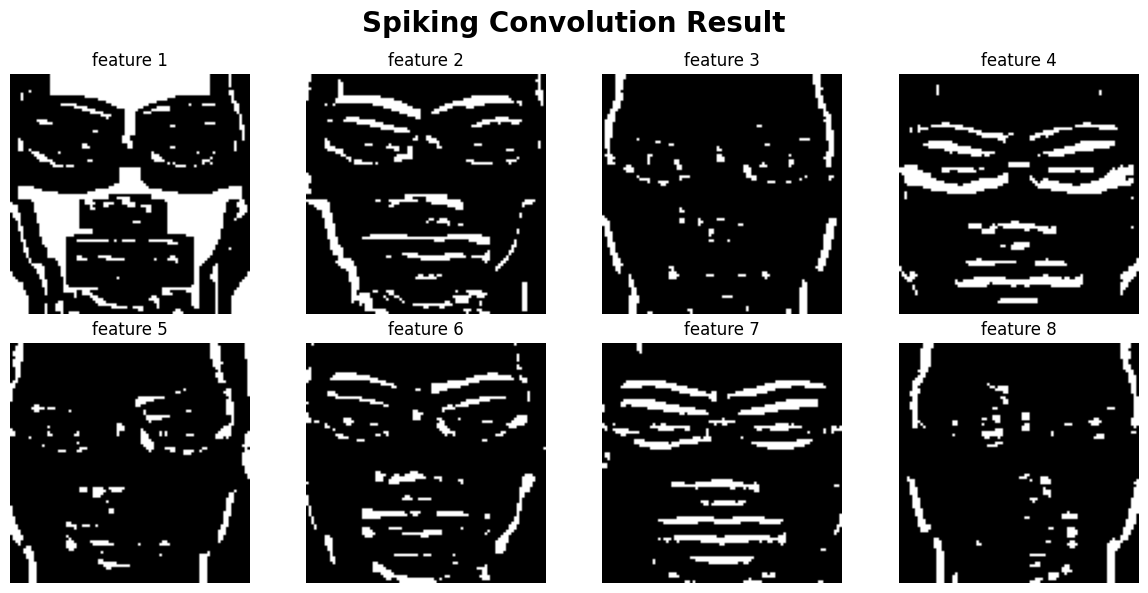

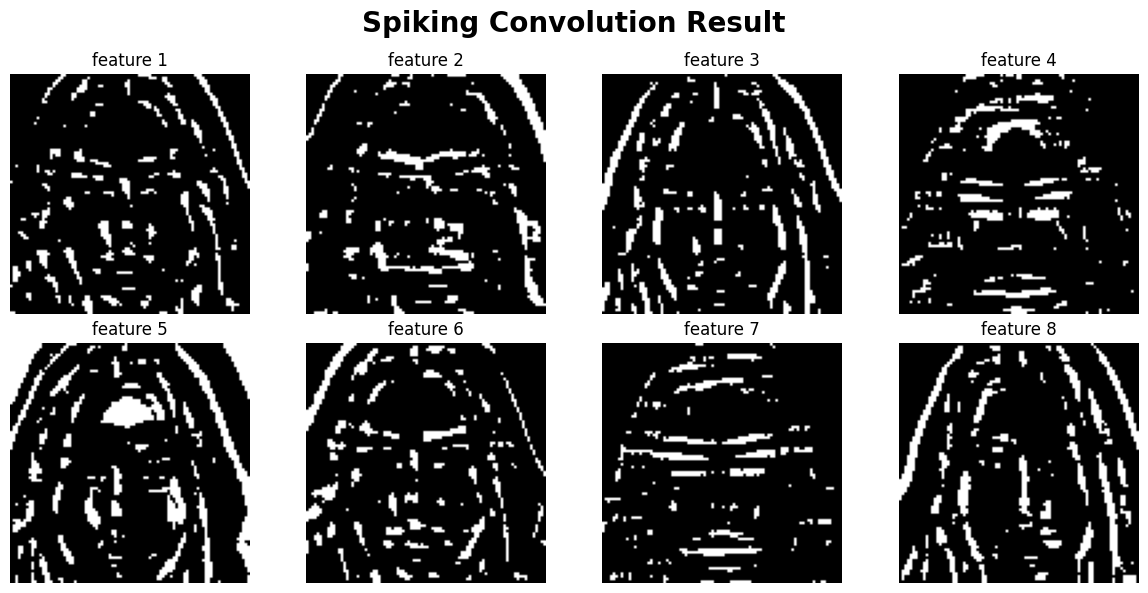

In [221]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=11,
    kernel_width=11,
    show_result_spike=True,
    show_last_spike=False,
    show_mean_spike=False,
    AP=5,
    AM=3.01,
)

1000xBatch: 1/1 (100%) 28837.411ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


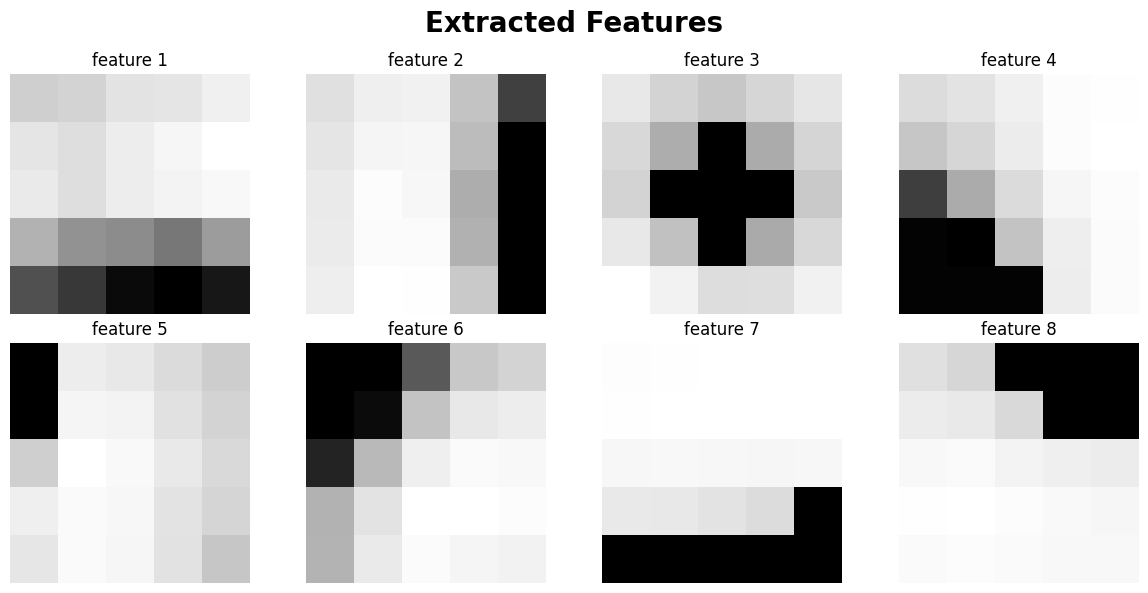

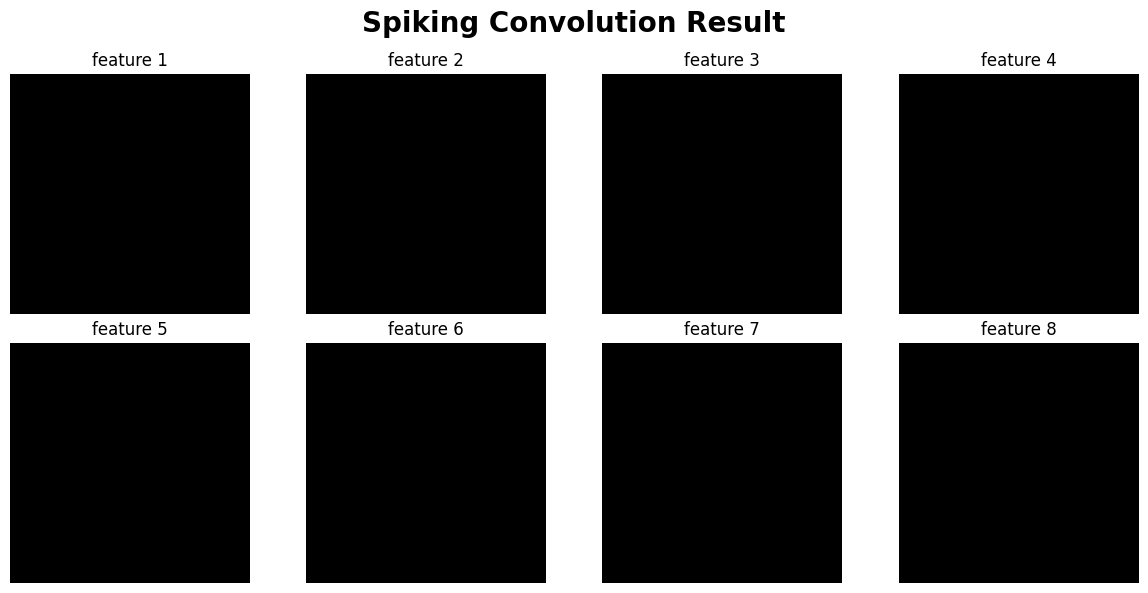

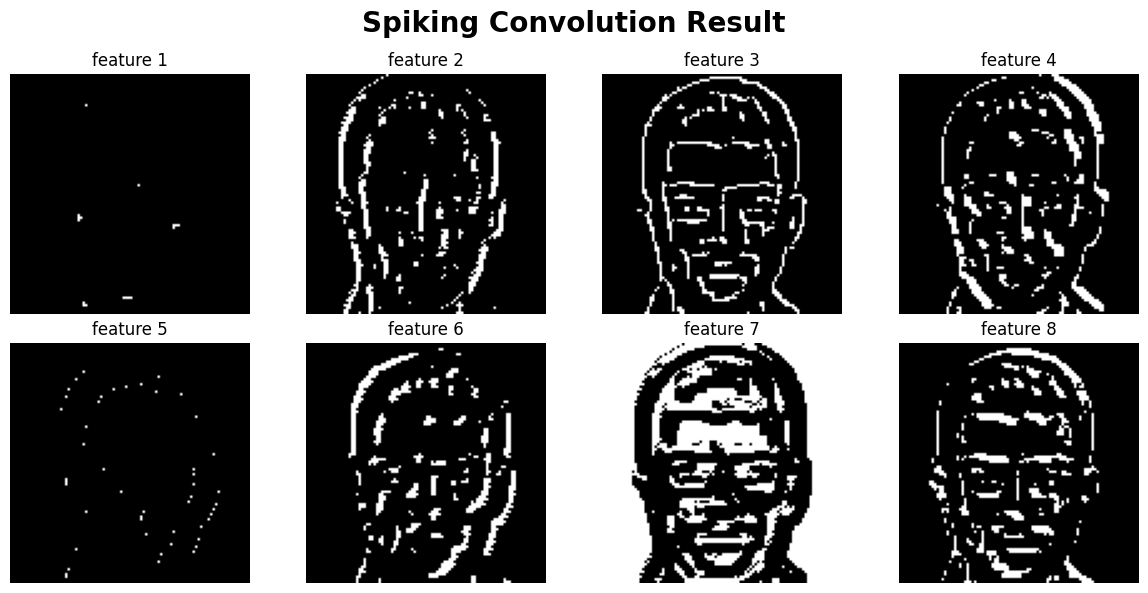

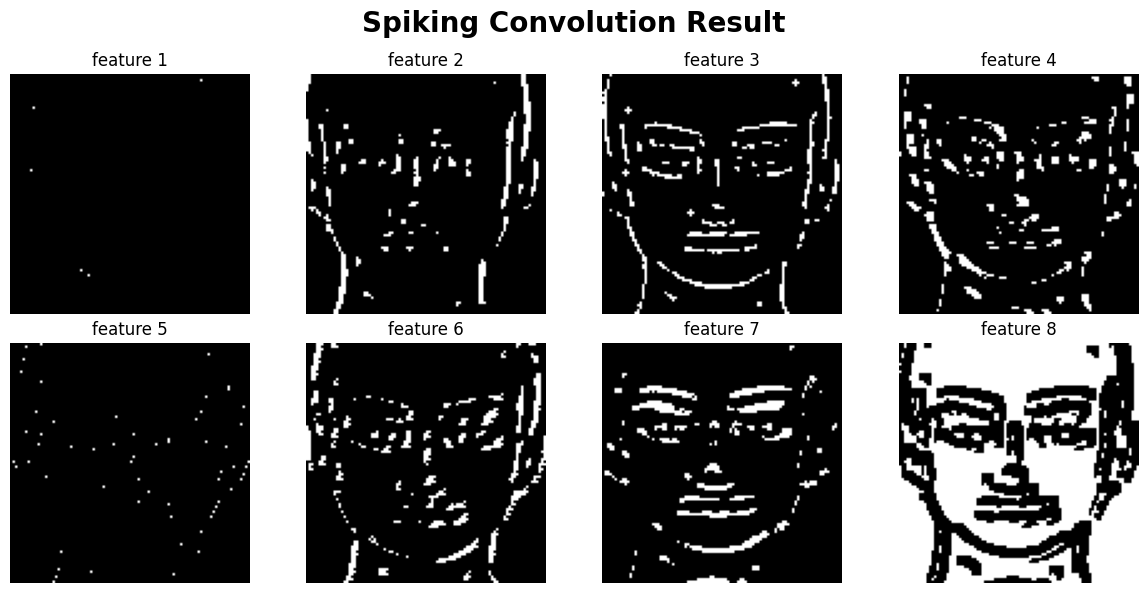

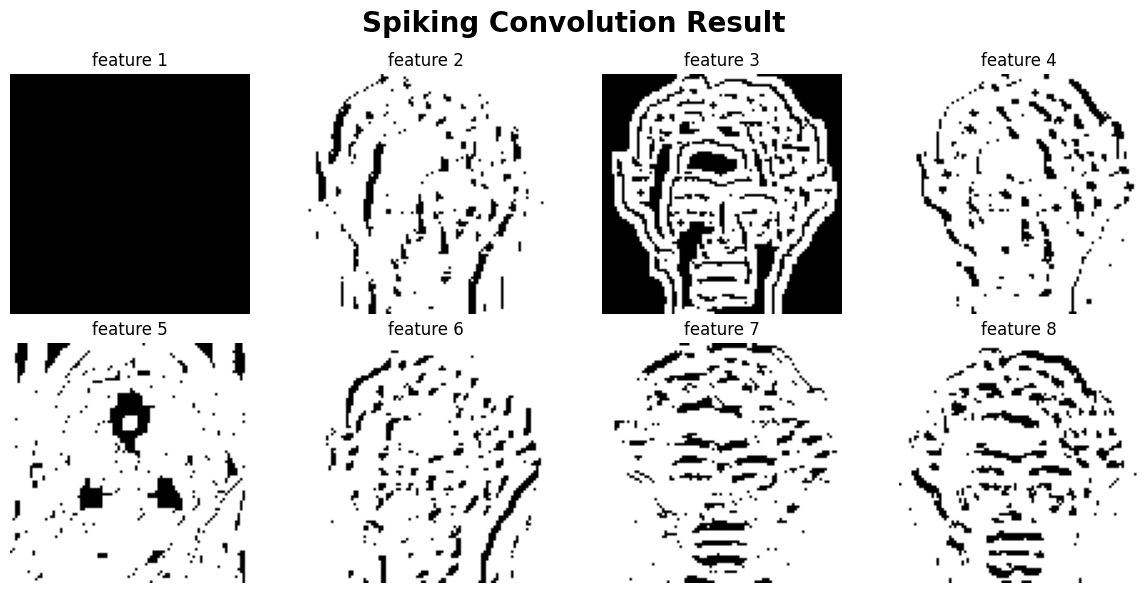

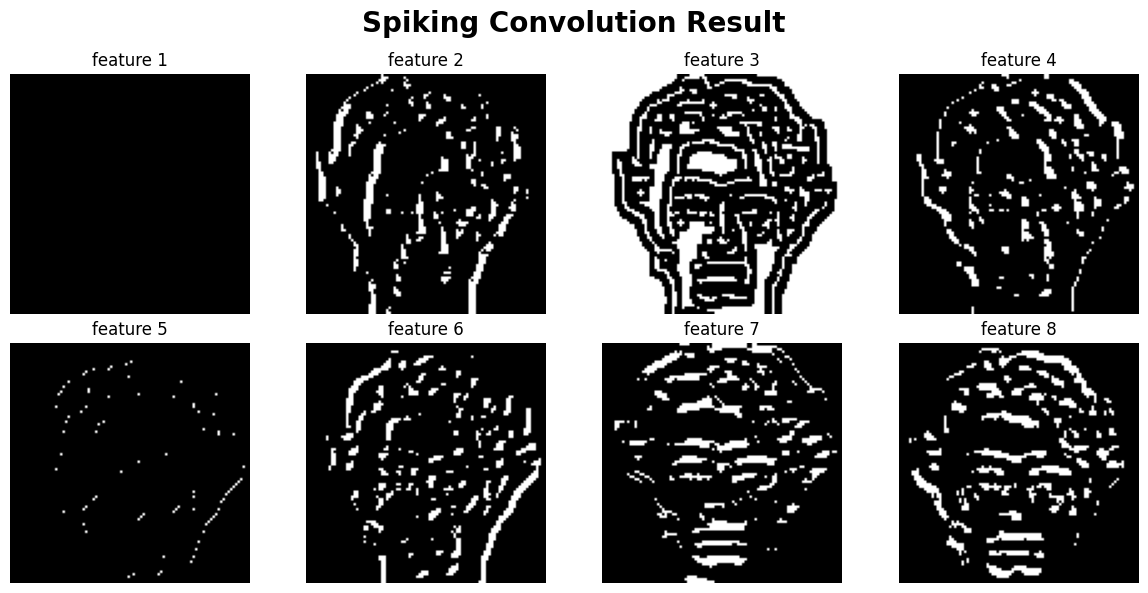

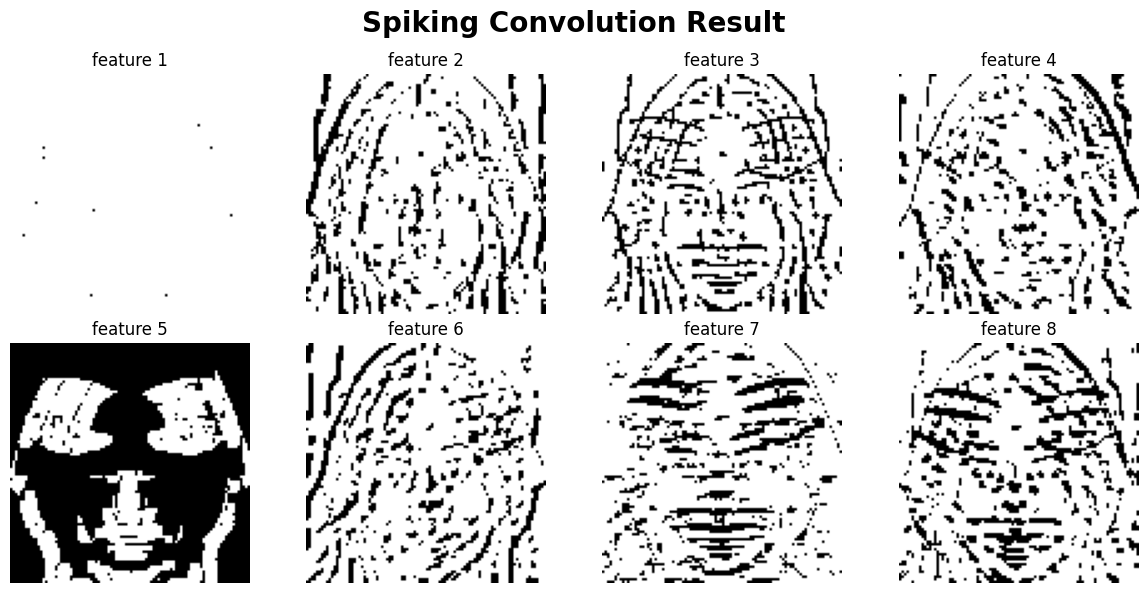

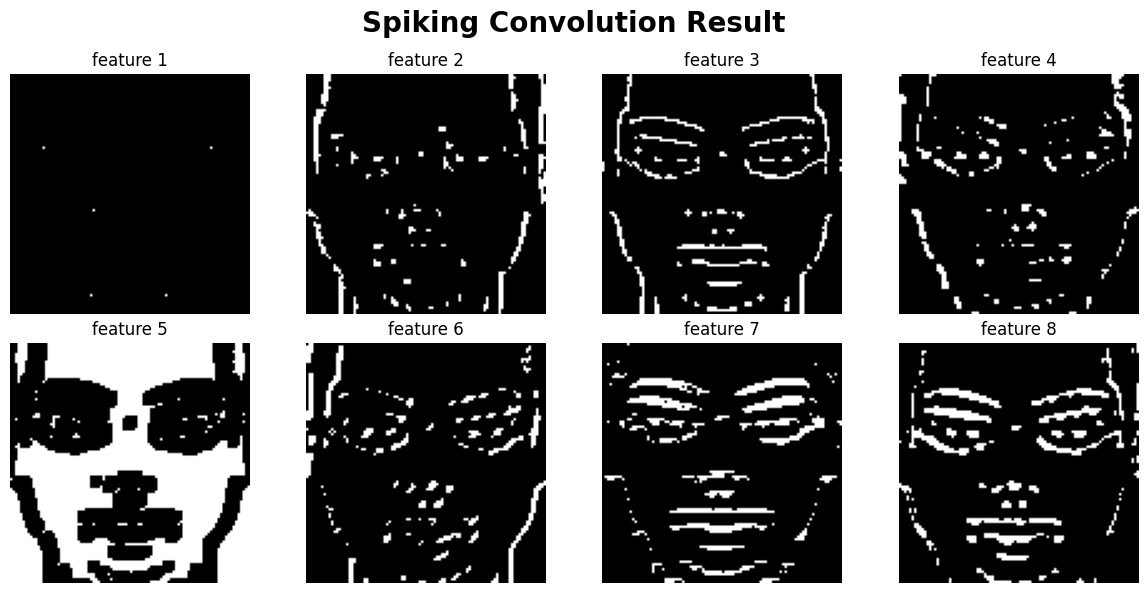

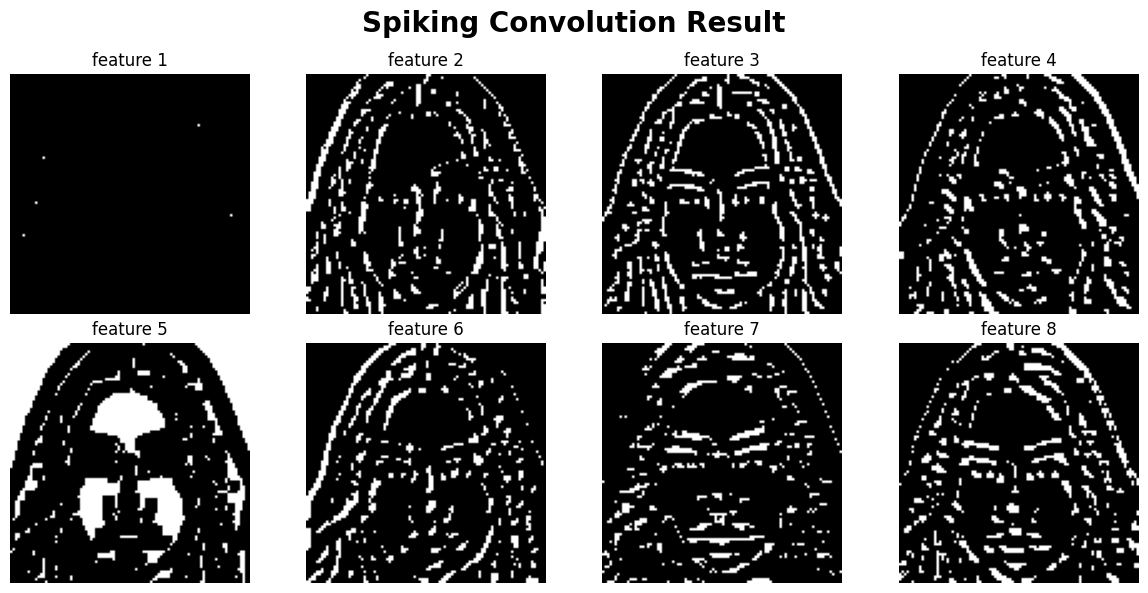

In [220]:
net2 = train(
    data,
    iterations=1000,
    activity_rate=0.2,
    rest_time=5,
    window_siz=2,
    kernel_height=5,
    kernel_width=5,
    show_result_spike=True,
    show_last_spike=False,
    show_mean_spike=False,
    AP=5,
    AM=3.01,
)

In [234]:

def train2(
    data,
    height=100,
    width=100,
    iterations=990,
    OUT_R = 10,
    OUT_THRESHOLD = 15,
    OUT_TAU = 3,
    OUT_V_RESET = 0,
    OUT_V_REST = 5,
    input_channels=1,
    kernel_height=100,
    kernel_width=100,
    f=8,
    activity_rate=0.1,
    window_siz=5,
    encode_method="ITL",
    show_weights=True,
    show_last_spike=True,
    show_mean_spike=True,
    show_result_spike=True,
    show_activity=False,
    print_convolution_result=True,
    rest_time=10,
    weight_mode="ones",
    sparsity=0.1,
    tau_sI=3,
    tau_sO=10,
    AP=2,
    AM=1,
    K=1,
    s=0.1,
    RECORDER_INDEX = 460,
    EV_RECORDER_INDEX = 461,
):

    layer2_height, layer2_width = (
        height - kernel_height + 1,
        width - kernel_width + 1,
    )
    net = Neocortex(dt=1, device="cpu", dtype=torch.float32)
    ng1 = NeuronGroup(
        size=NeuronDimension(height=height, width=width),
        behavior={
            **prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        R=OUT_R,
                        threshold=OUT_THRESHOLD,
                        tau=OUT_TAU,
                        v_reset=OUT_V_RESET,
                        v_rest=OUT_V_REST,
                    ),  # 260
                    Fire(),  # 340
                    SpikeTrace(tau_s=tau_sI),
                    NeuronAxon(),
                ]
            ),
            **{
                10: InpData.ResetMemory(),
                345: InpData.Encode(
                    data=torch.tensor(data),
                    # range=255,
                    time=window_siz,
                    sparsity=sparsity,
                    input_period=window_siz + rest_time,
                    ratio=0.05,
                    method=encode_method,
                ),
                # 350: act.Activity(),
                RECORDER_INDEX: Recorder(
                    variables=["spikes"],
                    tag="in_recorder",
                ),
                EV_RECORDER_INDEX: EventRecorder("spikes", tag="in_ev_recorder"),
            },
        },
        net=net,
    )

    ng2 = NeuronGroup(
        size=NeuronDimension(depth=f, height=layer2_height, width=layer2_width),
        net=net,
        behavior={
            **prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        tau=10,
                        v_rest=0,
                        v_reset=0,
                        threshold=1,
                        R=1,
                    ),
                    KWTA(k=K, dimension=0),
                    Fire(),
                    SpikeTrace(tau_s=tau_sO),
                    NeuronAxon(),
                    ActivityBaseHomeostasis(
                        activity_rate=activity_rate * window_siz,
                        window_size=(window_siz + rest_time)*f,
                        updating_rate=0.1,
                        # decay_rate=0.8,
                    ),
                ]
            ),
            **{
                RECORDER_INDEX: Recorder(variables=["spikes"], tag="out_recorder"),
                EV_RECORDER_INDEX: EventRecorder(
                    variables=["I", "spikes"], tag="out_ev_recorder"
                ),
            },
        },
    )
    synapse_input_layer2 = Synapsis(
        net=net,
        src=ng1,
        dst=ng2,
        synaptic_tag="Proximal",
        synapsis_behavior={
            **prioritize_behaviors(
                [
                    SynapseInit(),
                    WeightNormalization(),
                    WeightInitializer(
                        mode=weight_mode,
                        scale=5,
                        weight_shape=(f, input_channels, kernel_height, kernel_width),
                        kernel_shape=(f, input_channels, kernel_height, kernel_width),
                    ),
                    Conv2dDendriticInput(
                        current_coef= 20,
                    ),
                    Conv2dSTDP(
                        a_plus=AP * (kernel_height * kernel_width),
                        a_minus=AM * (kernel_height * kernel_width),
                        w_max=2 / (kernel_height * kernel_width),
                        positive_bound="soft_bound",
                        negative_bound="soft_bound",
                    ),
                ]
            ),
            **{
                RECORDER_INDEX: Recorder(tag="synapse_recorder", variables=["weights"]),
            },
        },
    )

    lateral_inhibition = Synapsis(
        net=net,
        src=ng2,
        dst=ng2,
        synaptic_tag="Proximal",
        synapsis_behavior=prioritize_behaviors(
            [
                SynapseInit(),
                WeightInitializer(
                    mode="ones",
                    scale=0.5,
                    weight_shape=(1, 1, 2 * f + 1, 1, 1),
                    kernel_shape=(1, 1, 2 * f + 1, 1, 1),
                ),
                LateralDendriticInput(inhibitory=True, current_coef=1000),
            ]
        ),
    )
    net.initialize(info=False)
    net.simulate_iterations(iterations)
    spikes = ng2.spikes.reshape(f, layer2_height, layer2_width)
    # spikes = ng2.spikes
    if show_activity:
        plt.scatter(
            ng1["in_ev_recorder", 0].variables["spikes"][:, 0].cpu(),
            ng1["in_ev_recorder", 0].variables["spikes"][:, 1].cpu(),
            s=s,
        )
        plt.title("input activity")
        plt.show()

        plt.scatter(
            ng2["out_ev_recorder", 0].variables["spikes"][:, 0].cpu(),
            ng2["out_ev_recorder", 0].variables["spikes"][:, 1].cpu(),
            s=s,
        )
        plt.title("output activity")

        plt.show()

    if show_weights:
        weights = synapse_input_layer2.synapses[0].weights.reshape(
                f, kernel_height, kernel_width
            )
        plot_grid(
            weights,
            f=f,
        )
        print([[w.max(),w.min()] for w in weights])


    if show_last_spike:
        spikes = ng2.spikes.reshape(f, layer2_height, layer2_width)
        plot_grid(spikes, f=f, title="Last spikes")

    if show_mean_spike:
        spikes = (
            ng2[RECORDER_INDEX, 0]
            .variables["spikes"]
            .reshape(iterations, f, layer2_height, layer2_width)
        )
        spikes = spikes.sum(axis=0, keepdim=True)[0]
        plot_grid(spikes, f=f, title="Mean of spikes")
    if show_result_spike:
        s= []
        spikes = ng1[RECORDER_INDEX, 0].variables["spikes"]
        spikes=spikes.reshape(iterations, height, width)
        for i in range(f):
            s.append(spikes[i*(rest_time+window_siz):(i+1)*(rest_time+window_siz)].sum(axis=0, keepdim=True)[0])
        plot_grid(s, f=f, title="Input Spikes")

    if show_result_spike:
        s=[]
        for i in range(f):

            spikes = (
                ng2[RECORDER_INDEX, 0]
                .variables["spikes"]
                .reshape(iterations, f, layer2_height, layer2_width)[
                    -(window_siz + rest_time) * (i + 1) : -(window_siz + rest_time) * i
                ]
            )
            spikes = spikes.sum(axis=0, keepdim=True)[0]
            plot_grid(spikes, f=f, title="Spiking Convolution Result")
            s.append(spikes.sum(axis=0, keepdim=True)[0])
            print(spikes.sum(axis=0, keepdim=True)[0].shape)
        plot_grid(spikes, f=f, title="Summation")

    return net

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 26054.156ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


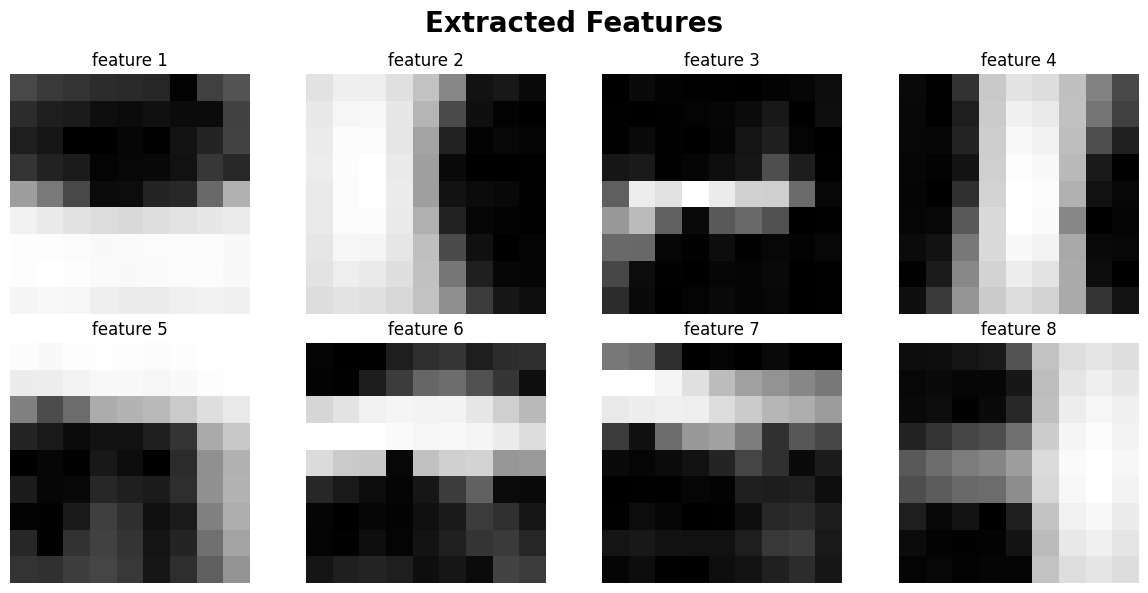

[[tensor(0.0240), tensor(4.7210e-05)], [tensor(0.0230), tensor(4.2559e-05)], [tensor(0.0813), tensor(1.3814e-05)], [tensor(0.0274), tensor(2.1873e-05)], [tensor(0.0273), tensor(0.0006)], [tensor(0.0339), tensor(6.2969e-05)], [tensor(0.0450), tensor(4.0187e-06)], [tensor(0.0251), tensor(5.9744e-05)]]
torch.Size([1000, 8, 1, 9, 9])


In [237]:
net2 = train2(
    data,
    iterations= 1000,
    activity_rate=0.1,
    rest_time=1,
    sparsity=0.1,
    window_siz=5,
    tau_sI=10,
    tau_sO=10,
    kernel_height=9,
    kernel_width=9,
    weight_mode="random",
    AP=11,
    AM=11 ,
    f=8,
    show_weights=True,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
)

1000xBatch: 1/1 (100%) 17712.783ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


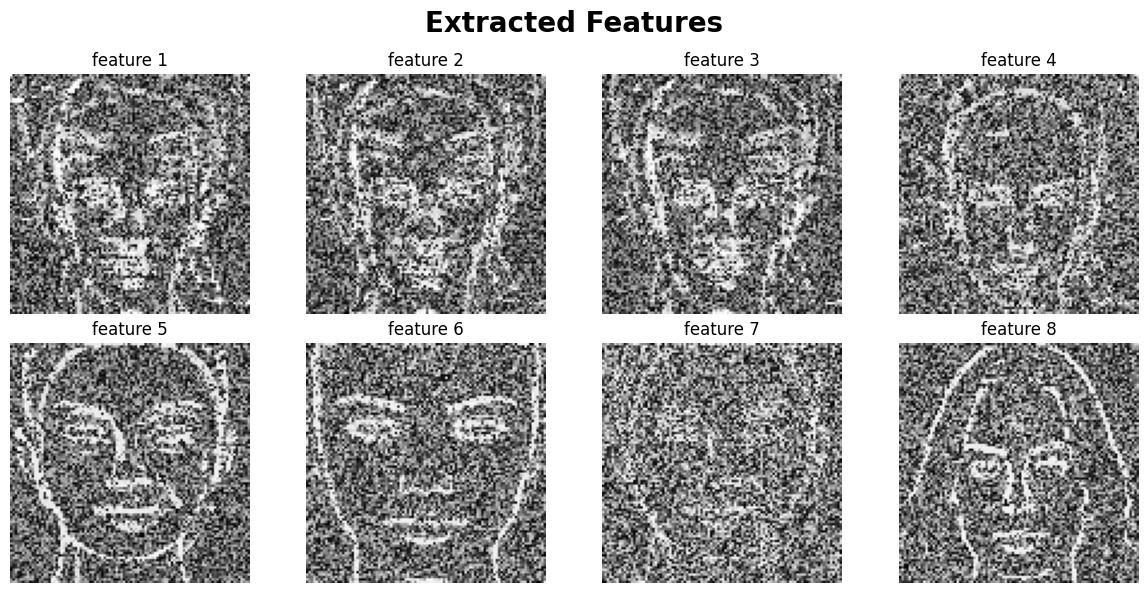

[[tensor(0.0002), tensor(1.2294e-08)], [tensor(0.0002), tensor(2.3182e-08)], [tensor(0.0002), tensor(9.5945e-09)], [tensor(0.0002), tensor(2.6949e-08)], [tensor(0.0002), tensor(2.2785e-08)], [tensor(0.0002), tensor(2.1263e-08)], [tensor(0.0002), tensor(1.4754e-08)], [tensor(0.0002), tensor(8.4909e-09)]]


In [218]:
net2 = train2(
    data,
    iterations= 1000,
    activity_rate=0.1,
    rest_time=1,
    sparsity=0.1,
    window_siz=5,
    tau_sI=10,
    tau_sO=10,
    kernel_height=100,
    kernel_width=100,
    weight_mode="random",
    AP=0.9999999,
    AM=0.0000001 ,
    f=8,
    show_weights=True,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 40893.998ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


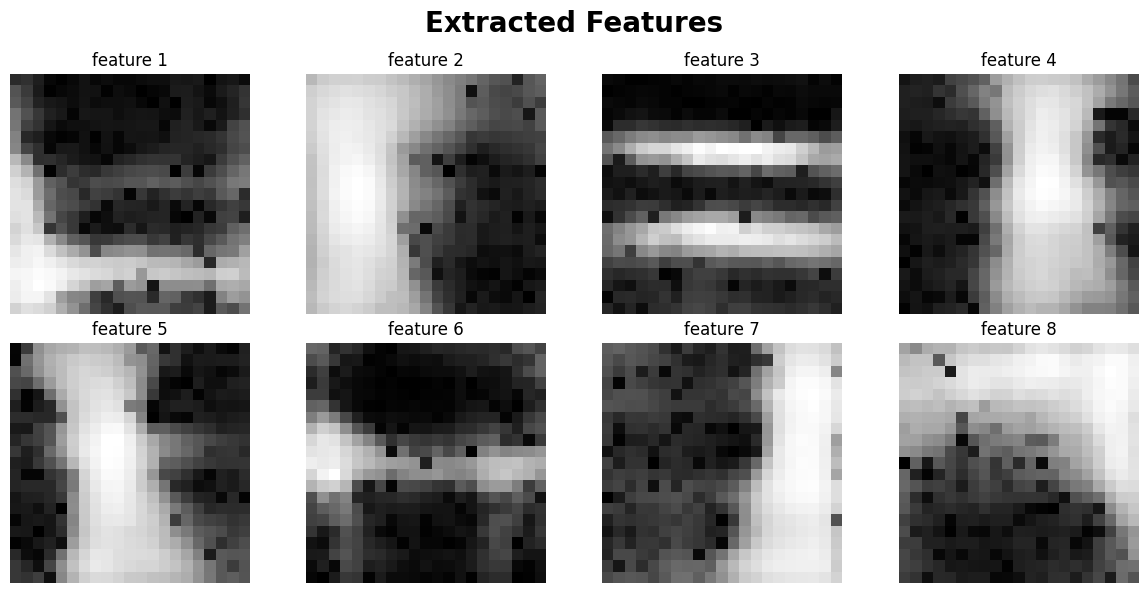

[[tensor(0.0069), tensor(2.7739e-06)], [tensor(0.0045), tensor(2.1417e-05)], [tensor(0.0073), tensor(3.1449e-07)], [tensor(0.0050), tensor(2.3967e-05)], [tensor(0.0050), tensor(1.1916e-05)], [tensor(0.0097), tensor(5.4984e-06)], [tensor(0.0049), tensor(7.6422e-06)], [tensor(0.0046), tensor(2.1049e-06)]]


In [233]:
net2 = train2(
    data,
    iterations= 1000,
    activity_rate=0.1,
    rest_time=1,
    sparsity=0.1,
    window_siz=5,
    tau_sI=10,
    tau_sO=10,
    kernel_height=21,
    kernel_width=21,
    weight_mode="random",
    AP=13,
    AM=12.55,
    f=8,
    show_weights=True,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 37247.560ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


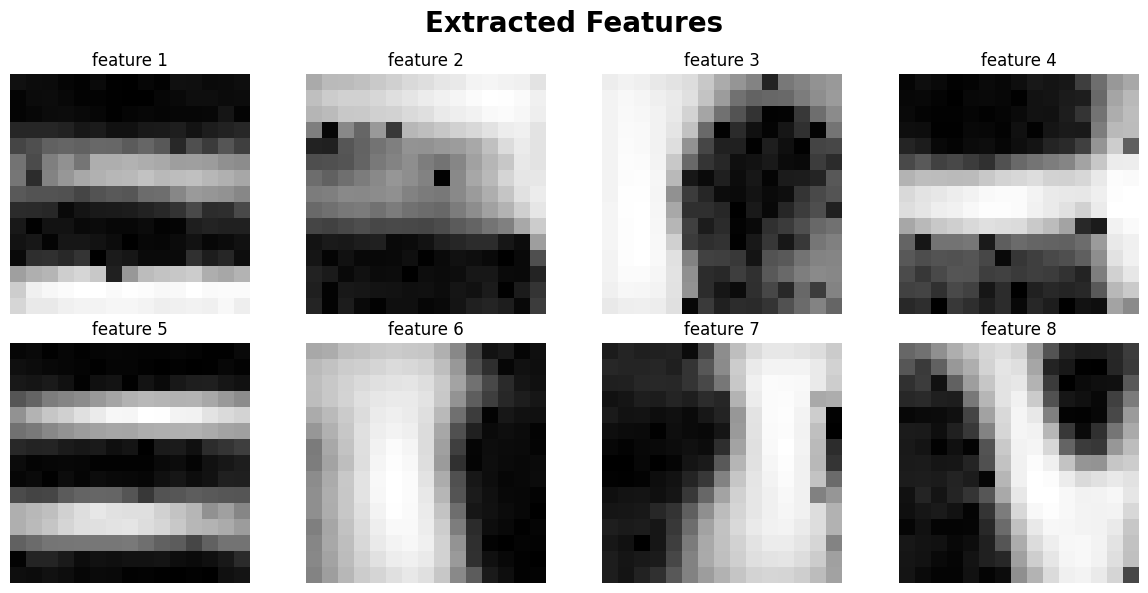

[[tensor(0.0129), tensor(4.9935e-06)], [tensor(0.0097), tensor(1.1926e-05)], [tensor(0.0090), tensor(1.2983e-05)], [tensor(0.0105), tensor(3.2646e-06)], [tensor(0.0138), tensor(1.1084e-05)], [tensor(0.0082), tensor(9.5538e-06)], [tensor(0.0091), tensor(3.6540e-05)], [tensor(0.0094), tensor(1.8060e-05)]]


In [232]:
net2 = train2(
    data,
    iterations= 1000,
    activity_rate=0.1,
    rest_time=1,
    sparsity=0.1,
    window_siz=5,
    tau_sI=10,
    tau_sO=10,
    kernel_height=15,
    kernel_width=15,
    weight_mode="random",
    AP=13,
    AM=12.55,
    f=8,
    show_weights=True,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 29727.427ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


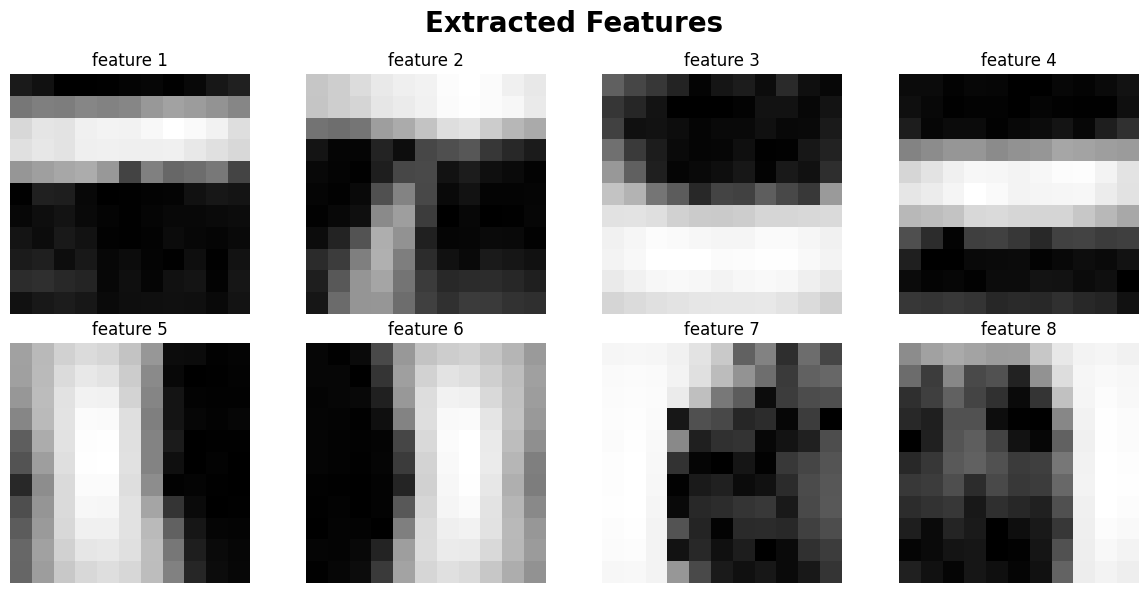

[[tensor(0.0275), tensor(0.0001)], [tensor(0.0225), tensor(1.6303e-05)], [tensor(0.0164), tensor(7.2828e-06)], [tensor(0.0235), tensor(6.6581e-05)], [tensor(0.0165), tensor(5.1480e-06)], [tensor(0.0166), tensor(7.8816e-07)], [tensor(0.0180), tensor(7.1707e-05)], [tensor(0.0184), tensor(3.9559e-07)]]


In [231]:
net2 = train2(
    data,
    iterations= 1000,
    activity_rate=0.1,
    rest_time=1,
    sparsity=0.1,
    window_siz=5,
    tau_sI=10,
    tau_sO=10,
    kernel_height=11,
    kernel_width=11,
    weight_mode="random",
    AP=13,
    AM=12.55,
    f=8,
    show_weights=True,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
)

/Users/delaram/Me/university/term 8/NS/homework/HW5/CodePart/Input.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[i])


1000xBatch: 1/1 (100%) 22200.757ms 400  |||| 500  |||| 600  |||| 700  |||| 800  |||| 900  |||| 1000  


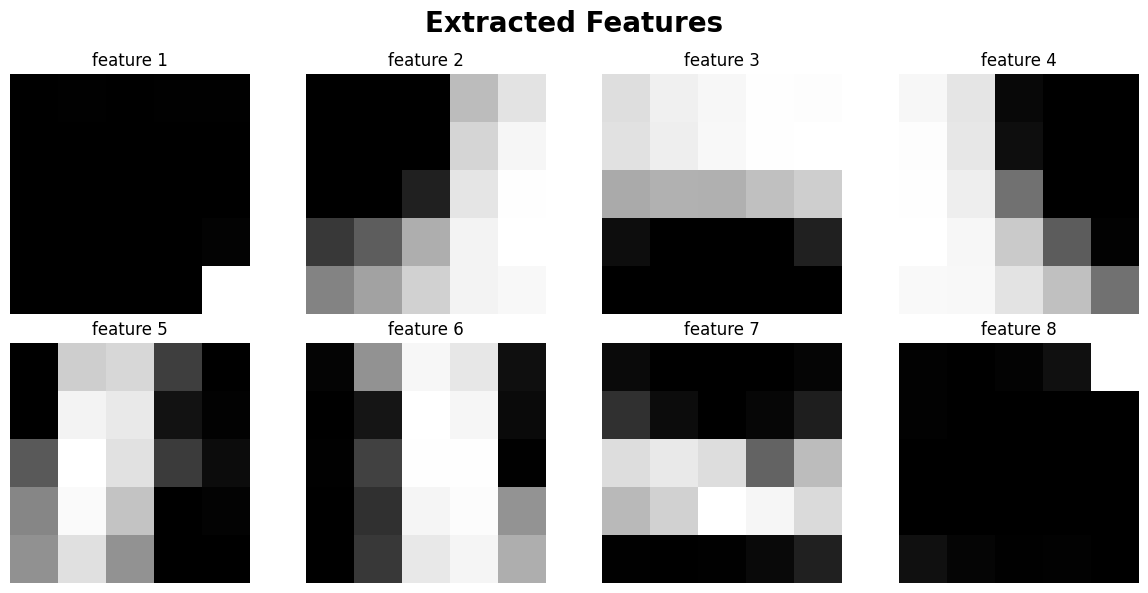

[[tensor(0.9576), tensor(3.0676e-06)], [tensor(0.0796), tensor(2.1623e-06)], [tensor(0.0750), tensor(4.9684e-06)], [tensor(0.0747), tensor(1.3846e-07)], [tensor(0.0937), tensor(1.0896e-05)], [tensor(0.0809), tensor(1.7722e-05)], [tensor(0.1139), tensor(0.0001)], [tensor(0.8270), tensor(1.0984e-05)]]


In [230]:
net2 = train2(
    data,
    iterations= 1000,
    activity_rate=0.1,
    rest_time=1,
    sparsity=0.1,
    window_siz=5,
    tau_sI=10,
    tau_sO=10,
    kernel_height=5,
    kernel_width=5,
    weight_mode="random",
    AP=13,
    AM=12.55,
    f=8,
    show_weights=True,
    show_last_spike=False,
    show_mean_spike=False,
    show_result_spike=False,
)